# Preprocessing

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

newspaper_df = pd.read_excel('data/NewspaperChurn_new_version.xlsx')
display(newspaper_df.head())
display(newspaper_df.info())

,SubscriptionID,HH Income,Home Ownership,Ethnicity,dummy for Children,Year Of Residence,Age range,Language,Address,State,City,County,Zip Code,weekly fee,Deliveryperiod,Nielsen Prizm,reward program,Source Channel,Subscriber
0,180590686,"$ 30,000 - $39,999",RENTER,German,N,1,25-29,German,1 3RD PL UNIT 703,CA,LONG BEACH,LOS ANGELES,90802,$7.00 - $7.99,7Day,FM,0,CircAdm,NO
1,181401653,"$500,000 Plus",OWNER,unknown,Y,14,50-54,NaN,1 AVIGNON,CA,NEWPORT COAST,ORANGE,92657,$0.01 - $0.50,SunOnly,MW,0,Partner,YES
2,180374685,"$100,000 - $124,999",OWNER,Italian,Y,7,45-49,English,1 BLACKSWAN,CA,IRVINE,ORANGE,92604,$0.01 - $0.50,SunOnly,MW,0,Partner,YES
3,180703483,"$200,000 - $249,999",OWNER,English,N,23,55-59,English,1 BLUE HORIZON,CA,LAGUNA NIGUEL,ORANGE,92677,$1.00 - $1.99,SunOnly,MW,1,Internet,NO
4,180358906,"$ 50,000 - $59,999",OWNER,Italian,N,23,60-64,English,1 BRISA DEL LAGO,CA,RANCHO SANTA MARGARITA,ORANGE,92688,$8.00 - $8.99,Thu-Sun,MM,0,Crew,YES


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SubscriptionID      15855 non-null  int64 
 1   HH Income           15855 non-null  object
 2   Home Ownership      15855 non-null  object
 3   Ethnicity           15855 non-null  object
 4   dummy for Children  15855 non-null  object
 5   Year Of Residence   15855 non-null  int64 
 6   Age range           15747 non-null  object
 7   Language            14848 non-null  object
 8   Address             15855 non-null  object
 9   State               15855 non-null  object
 10  City                15855 non-null  object
 11  County              15855 non-null  object
 12  Zip Code            15855 non-null  int64 
 13  weekly fee          15669 non-null  object
 14  Deliveryperiod      15855 non-null  object
 15  Nielsen Prizm       15726 non-null  object
 16  reward program      15

None

In [238]:
# 수치형, 범주형 데이터 컬럼 조회
numerical = newspaper_df.select_dtypes(include=["int64"]).columns.tolist()
categorical = newspaper_df.select_dtypes(include=["object"]).columns.tolist()
print(numerical)
print(categorical)

['SubscriptionID', 'Year Of Residence', 'Zip Code', 'reward program']
['HH Income', 'Home Ownership', 'Ethnicity', 'dummy for Children', 'Age range', 'Language', 'Address', 'State', 'City', 'County', 'weekly fee', 'Deliveryperiod', 'Nielsen Prizm', 'Source Channel', 'Subscriber']


## 0. Target 값 (Subscriber) binary 변환 (is_churned이라는 새로운 target 컬럼 생성) 
- 'YES', 'NO' => **is_churned**이 1 (이탈) 혹은 0 (이탈 X)

In [239]:
# 예시: Subscirber==0  =  is_churned==1 
newspaper_df['is_churned'] = newspaper_df['Subscriber'].apply(lambda x: 1 if x == 'NO' else 0)

## 1. 결측치 처리

In [240]:
newspaper_df.isna().sum()

SubscriptionID           0
HH Income                0
Home Ownership           0
Ethnicity                0
dummy for Children       0
Year Of Residence        0
Age range              108
Language              1007
Address                  0
State                    0
City                     0
County                   0
Zip Code                 0
weekly fee             186
Deliveryperiod           0
Nielsen Prizm          129
reward program           0
Source Channel           0
Subscriber               0
is_churned               0
dtype: int64

### 1.1. 나이구간 결측치 처리

In [241]:
# 'Age range'가 null인 row 제거
newspaper_df = newspaper_df.dropna(subset=['Age range'])

### 1.2 Language 결측치 처리
- 결측이 약 6.3%가 되기 때문에 무작정 삭제 하는 것이 옳바르지는 않음
- **언어가 Unknown인 부류와 아닌 부류의 이탈률에 의미 있는 차이가 없음**
- Language는 보조적 분류 변수로서 사용될 가능성이 있음
- language 보다 더 중요한 특성들의 행까지 삭제되는 것을 방지할 필요가 있음
  
**따라서 현재 분석에선 "Unknown"으로 처리하는 방식이 더 안전하고 실용적**

In [242]:
newspaper_df['Language'].isna().sum()

np.int64(1000)

In [243]:
newspaper_df['Language'].isna().sum()
## 결측값을 Unknown으로 부여했을 때 이탈율 비교

# Language 컬럼의 결측값을 'Unknown'으로 대체
newspaper_df['Language'] = newspaper_df['Language'].fillna('Unknown')


# 언어가 Unknown인 경우와 아닌 경우로 나누어 이탈률 비교
churn_unknown = newspaper_df[newspaper_df['Language'] == 'Unknown']['is_churned'].mean()
churn_known = newspaper_df[newspaper_df['Language'] != 'Unknown']['is_churned'].mean()

print(f"이탈률 (Language = Unknown): {churn_unknown:.4f}")
print(f"이탈률 (Language ≠ Unknown): {churn_known:.4f}")

이탈률 (Language = Unknown): 0.8050
이탈률 (Language ≠ Unknown): 0.8083


### 1.3. Weekley Fee 결측치 처리
- 결측률: 약 1.8%
- 이탈 데이터는 충분히 많기 때문에 지우기로 결정

In [244]:
newspaper_df['weekly fee'].unique()

array(['$7.00 - $7.99', '$0.01 - $0.50', '$1.00 - $1.99', '$8.00 - $8.99',
       '$0 - $0.01', '$2.00 - $2.99', '$9.00 - $9.99', '$4.00 - $4.99',
       '$0.51 - $0.99', '$3.00 - $3.99', '$5.00 - $5.99', '$6.00 - $6.99',
       '$10.00 - $10.99', nan, '$0'], dtype=object)

In [245]:
# 결측 vs 비결측 이탈률 확인
isnull_group = newspaper_df[newspaper_df['weekly fee'].isnull()]
notnull_group = newspaper_df[newspaper_df['weekly fee'].notnull()]

churn_null = isnull_group['is_churned'].mean()
churn_notnull = notnull_group['is_churned'].mean()

print(f"이탈률 (요금 결측): {churn_null:.4f}")
print(f"이탈률 (요금 있음): {churn_notnull:.4f}")

이탈률 (요금 결측): 1.0000
이탈률 (요금 있음): 0.8058


In [246]:
newspaper_df = newspaper_df.dropna(subset=['weekly fee'])

### 1.4. Nielsen Prizm 전처리 (우선 drop 채택, 추가적인 고려 필요)
**Nielsen Prizm**: 소비자의 인구통계학적 특성과 라이프스타일에 따라 고객을 여러 세그먼트로 분류하는 코드 기반 마케팅 세분화 시스템 (연령, 성별, 가족 구성 또는 경제 활동 상태 등을 요약적으로 표현)이라고 추정 => **이 특성이 나이와 소득을 반영한다면 어떻게 처리할 지 고민을 해봐야 함**

- 결측치가 0.8% 정도 밖에 차지 안하므로, null 값 row는 제거 

In [247]:
# 유니크 값 확인
newspaper_df['Nielsen Prizm'].unique()

array(['FM', 'MW', 'MM', 'FW', 'YW', 'YM', nan, 'ME', 'YE', 'FE'],
      dtype=object)

In [248]:
newspaper_df = newspaper_df.dropna(subset=['Nielsen Prizm'])

## 2. 범주형 데이터 처리
- 범주형 데이터 중 unknown 범주를 가지는 컬럼 조회

In [249]:
# 범주형 데이터 중 unknown 범주를 가지는 컬럼 조회

for col in categorical:
    if newspaper_df[col].astype(str).str.lower().isin(['unknown']).any():
        unique_vals = newspaper_df[col].unique()
        print(f"{col}: {unique_vals}")

Ethnicity: ['German' 'unknown' 'Italian' 'English' 'Scottish (Scotch)' 'Hispanic'
 'Chinese' 'Irish' 'Swedish' 'Filipino (Philippine)' 'Jewish' 'Arab'
 'Japanese' 'Indian' 'Vietnamese' 'Persian' 'French' 'Korean' 'Turkish'
 'Norwegian' 'Armenian' 'Polish' 'Portuguese' 'Dutch' 'Welsh' 'Belgian'
 'Byelorussian (Belarusian)' 'Czech' 'Thai' 'Ukrainian' 'African (other)'
 'Danish' 'Native American (American Indian)' 'Zimbabwean' 'Hungarian'
 'Russian' 'Austrian' 'Pakistani' 'Greek' 'Khmer (Kampuchean, Cambodian)'
 'Lithuanian' 'Romanian' 'African American 95%+' 'Egyptian' 'Ethiopian'
 'multi-ethnic' 'Slovakian (Slovak)' 'Serbian' 'Swiss' 'Laotian' 'Ugandan'
 'Finnish' 'Croatian' 'Ruandan (Rwandan)' 'Malawian' 'Indonesian'
 'Angolan' 'Latvian' 'Iraqi' 'Hawaiian' 'Syrian' 'Albanian' 'Ghanaian'
 'Slovenian (Slovene)' 'Kenyan' 'Myanmar (Burma)' 'Bulgarian' 'Bhutanese'
 'Swaziland' 'Nigerian' 'Luxembourgian' 'Estonian'
 'Zairian (Democratic Republic of the Con']
Language: ['German' 'Unknown' 'En

- Language는 결측치 처리에서 unknown을 만든 것이므로 제외
- Ethnicity의 unknown 범주에 속하는 데이터 개수는 Language와 똑같이 6.3%. 

In [250]:
newspaper_df[newspaper_df['Ethnicity'].astype(str).str.lower() == 'unknown'].shape[0] / newspaper_df.shape[0] * 100

6.32853996631688

- Language의 경우와 똑같은 비율이므로 두 변수의 unknown이 공통인지 확인해본 결과 서로 일치
- Ethnicity 컬럼도 unknown 범주 유지 결정

In [251]:
mask_ethnicity = newspaper_df['Ethnicity'].astype(str).str.lower() == 'unknown'
mask_language = newspaper_df['Language'].astype(str).str.lower() == 'unknown'

both_unknown = (mask_ethnicity & mask_language).sum()

ethnicity_unknown = mask_ethnicity.sum()
language_unknown = mask_language.sum()

print(f"Ethnicity == 'unknown'인 행 수: {ethnicity_unknown}")
print(f"Language == 'unknown'인 행 수: {language_unknown}")
print(f"둘 다 'unknown'인 행 수: {both_unknown}")

Ethnicity == 'unknown'인 행 수: 977
Language == 'unknown'인 행 수: 977
둘 다 'unknown'인 행 수: 977


- Deliveryperiod 컬럼은 대소문자가 다른 중복 범주 존재.
- 범주명을 소문자로 통일

In [252]:
newspaper_df['Deliveryperiod'] = newspaper_df['Deliveryperiod'].astype(str).str.lower()
newspaper_df['Deliveryperiod'].unique()

array(['7day', 'sunonly', 'thu-sun', 'satsun', '7dayol', 'sooooos',
       'mon-fri', 'soooofs', 'soooooot', '7dayt', 'fri-sun', 'soootfs',
       'sunonlyt', 'soooooo', 'thu-sunt', 'omtwtfo', 'fri-sunt',
       'soootfst', 'sun-fri', 'sooooost', 'sun-frit', 'soooofst'],
      dtype=object)

## 3. 이상치 처리
- 수치형 변수들 간의 이상치 조회
- 거주기간의 경우, 큰 이상치는 존재하지 않으므로 처리하지 않음
- reward program의 경우 극단치가 존재하지만 할인 관련 혜택을 받는 횟수를 나타내는 특성이고 대부분이 0에 분포하다 보니 이상치여도 중요한 특성을 담고 있다고 판단하여 처리하지 않음

In [253]:
print(numerical)

['SubscriptionID', 'Year Of Residence', 'Zip Code', 'reward program']


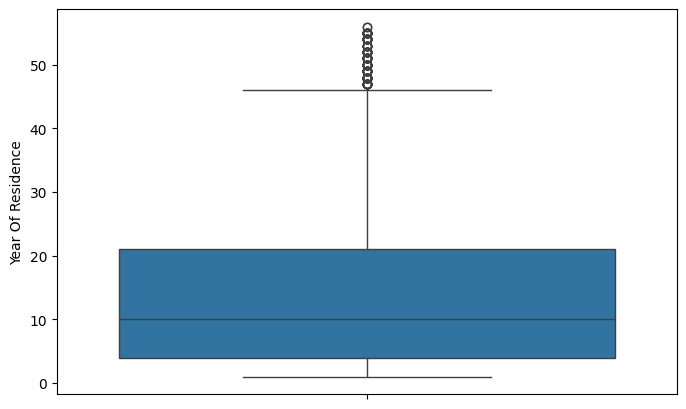

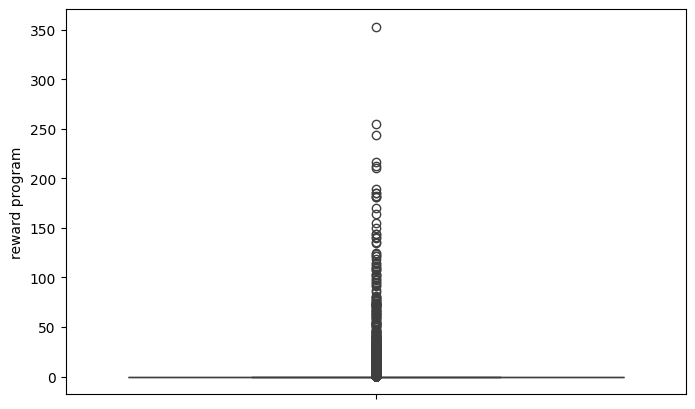

In [254]:
# boxplot을 사용하여 각 변수의 이상치 시각화
for var in ['Year Of Residence', 'reward program']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=newspaper_df[var])
    plt.show()

## 4. 불필요한 컬럼 삭제
- 파생변수로 인해 불필요해진 기존 컬럼 ('Subscriber')
- 뚜렷한 관련이 없는 컬럼('SubscriptionID', 'State', 'Zip Code', 'Address')

In [255]:
newspaper_df.columns.to_list()

['SubscriptionID',
 'HH Income',
 'Home Ownership',
 'Ethnicity',
 'dummy for Children',
 'Year Of Residence',
 'Age range',
 'Language',
 'Address',
 'State',
 'City',
 'County',
 'Zip Code',
 'weekly fee',
 'Deliveryperiod',
 'Nielsen Prizm',
 'reward program',
 'Source Channel',
 'Subscriber',
 'is_churned']

In [256]:
newspaper_df.drop(['SubscriptionID', 'State', 'Zip Code', 'Address', 'Subscriber'], axis=1, inplace=True)
# 최종 확인
newspaper_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15438 entries, 0 to 15854
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   HH Income           15438 non-null  object
 1   Home Ownership      15438 non-null  object
 2   Ethnicity           15438 non-null  object
 3   dummy for Children  15438 non-null  object
 4   Year Of Residence   15438 non-null  int64 
 5   Age range           15438 non-null  object
 6   Language            15438 non-null  object
 7   City                15438 non-null  object
 8   County              15438 non-null  object
 9   weekly fee          15438 non-null  object
 10  Deliveryperiod      15438 non-null  object
 11  Nielsen Prizm       15438 non-null  object
 12  reward program      15438 non-null  int64 
 13  Source Channel      15438 non-null  object
 14  is_churned          15438 non-null  int64 
dtypes: int64(3), object(12)
memory usage: 1.9+ MB


In [257]:
# 수치형, 범주형 데이터 컬럼 조회
numerical = newspaper_df.select_dtypes(include=["int64"]).columns.tolist()
categorical = newspaper_df.select_dtypes(include=["object"]).columns.tolist()
print(numerical)
print(categorical)

['Year Of Residence', 'reward program', 'is_churned']
['HH Income', 'Home Ownership', 'Ethnicity', 'dummy for Children', 'Age range', 'Language', 'City', 'County', 'weekly fee', 'Deliveryperiod', 'Nielsen Prizm', 'Source Channel']


## EDA

In [258]:
import pandas as pd
from scipy.stats import chi2_contingency

# helper fucntion

overall_churn_rate = newspaper_df['is_churned'].mean()
min_count_threshold = 100  # 기준값, 조정 가능

# 범주형 변수에서 빈도수 100 미만인 범주 other 그룹으로 묶기
def group_low_freq_categories(df, col, threshold):
    counts = df[col].value_counts()
    to_replace = counts[counts < threshold].index
    df_copy = df.copy()
    df_copy[col] = df_copy[col].apply(lambda x: 'Other' if x in to_replace else x)
    return df_copy

# 범주마다 이탈률 계산 및 평균 이탈률 대비 차이를 시각화
def plot_churn_rate_difference(df, category_col, title):
    churn_rate_by_cat = df.groupby(category_col)['is_churned'].mean()
    count_by_cat = df[category_col].value_counts()
    diff_from_mean = churn_rate_by_cat - overall_churn_rate
    
    result_df = pd.DataFrame({
        'Churn Rate': churn_rate_by_cat,
        'Difference from Mean': diff_from_mean,
        'Count': count_by_cat
    }).sort_values(by='Churn Rate', ascending=False).reset_index()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(data=result_df, x=category_col, y='Churn Rate', ax=ax, color='lightblue')
    ax.axhline(overall_churn_rate, color='red', linestyle='--', label=f'Overall Churn Rate ({overall_churn_rate:.3f})')
    ax.set_ylabel('Churn Rate')
    ax.set_xlabel(category_col)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=90)
    
    for i, diff in enumerate(result_df['Difference from Mean']):
        ax.text(i, result_df['Churn Rate'].iloc[i] + 0.01,
                f"{diff:+.3f}", ha='center', color='black')
    
    ax.legend()
    plt.tight_layout()
    plt.show()

# 연속형 변수(거주기간, 보상 프로그램)를 구간 별로 나누고 평균 이탈률 대비 차이를 시각화 맟 카이제곱 검증
def plot_churn_rate_by_numeric_bin(df, col, bins=10, log_x=False):
    data = df[[col, 'is_churned']].dropna().copy()
    
    # 로그 스케일 옵션 처리
    if log_x:
        data = data[data[col] > 0]
    
    # 구간(bin) 만들기
    data['bin'] = pd.cut(data[col], bins=bins)
    
    # 구간별 이탈률
    grouped = data.groupby('bin')['is_churned'].agg(['mean', 'count']).reset_index()
    grouped.rename(columns={'mean':'churn_rate', 'count':'total'}, inplace=True)
    
    # --- 카이제곱 검정 ---
    contingency = pd.crosstab(data['bin'], data['is_churned'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.values.sum()
    r, k = contingency.shape
    cramers_v = np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

    print(f"Category: {col}")
    print(f"Chi2 statistic: {chi2:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p:.4e}")
    print(f"Cramér's V (effect size): {cramers_v:.4f}")
    if p < 0.05:
        print("=> 통계적으로 유의미한 관련성이 있습니다.\n")
    else:
        print("=> 통계적으로 유의미한 관련성이 없습니다.\n")
    
    # 시각화
    plt.figure(figsize=(10,6))
    sns.barplot(data=grouped, x='bin', y='churn_rate', color='lightcoral')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Churn Rate')
    plt.title(f'Churn Rate by {col} bins\nChi2={chi2:.2f}, p={p:.4f}')
    
    # 전체 평균 이탈률 선
    overall_churn_rate = data['is_churned'].mean()
    plt.axhline(overall_churn_rate, color='blue', linestyle='--', label='Overall Churn Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 카이제곱 검증 전 빈도수 100 미만인 범주 제외
def filter_low_freq_categories(df, col, threshold=100):
    counts = df[col].value_counts()
    valid_categories = counts[counts >= threshold].index
    return df[df[col].isin(valid_categories)]

# 카이제곱 검증
def chi2_test_on_category(df, category_col):
    contingency = pd.crosstab(df[category_col], df['is_churned'])
    chi2, p, dof, expected = chi2_contingency(contingency)

    n = contingency.values.sum()
    r, k = contingency.shape
    cramers_v = np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

    print(f"Category: {category_col}")
    print(f"Chi2 statistic: {chi2:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p:.4e}")
    print(f"Cramér's V (effect size): {cramers_v:.4f}")
    if p < 0.05:
        print("=> 통계적으로 유의미한 관련성이 있습니다.\n")
    else:
        print("=> 통계적으로 유의미한 관련성이 없습니다.\n")

### 이탈 vs 잔류 전체 비율 시각화

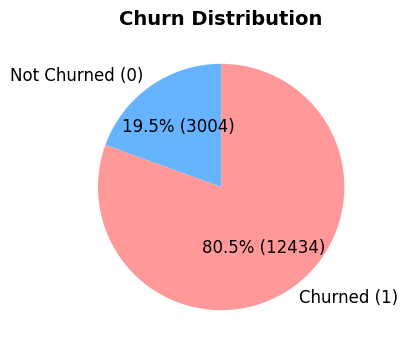

In [259]:
import matplotlib.pyplot as plt

# Count churn values
churn_counts = newspaper_df['is_churned'].value_counts().sort_index()

# Prepare labels with actual counts
labels = [
    f'Not Churned (0)',
    f'Churned (1)'
]

# Prepare sizes
sizes = churn_counts.values

# Pie plot
fig, ax = plt.subplots(figsize=(4, 4))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f'{p:.1f}% ({int(round(p * sum(sizes) / 100))})',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    textprops={'fontsize': 12}
)

# Title
ax.set_title('Churn Distribution', fontsize=14, fontweight='bold')

plt.show()

## 집 소유 여부 별 이탈 vs 잔류 카운트

- 집 소유별 이탈과 잔류 수 히스토그램 비교
- 평균 이탈률 대비 집 소유별 이탈률 차이 비교
- 카이제곱 검정을 통한 집 소유별 이탈률의 독립 여부 평가

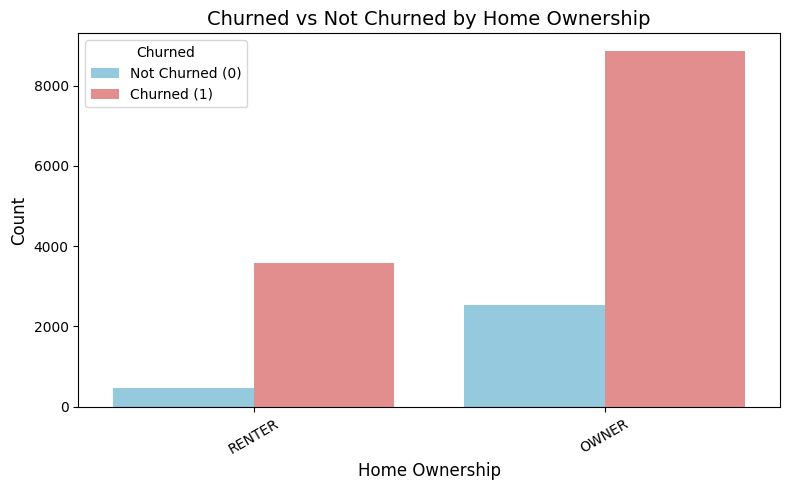

In [260]:
plt.figure(figsize=(8, 5))
sns.countplot(data=newspaper_df, x='Home Ownership', hue='is_churned',
              palette=['skyblue', 'lightcoral'])

plt.title('Churned vs Not Churned by Home Ownership', fontsize=14)
plt.xlabel('Home Ownership', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Churned', labels=['Not Churned (0)', 'Churned (1)'])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

                    mean  count
Home Ownership                 
OWNER           0.776794  11402
RENTER          0.886274   4036
0.8054152092239928
Home Ownership
OWNER     0.776794
RENTER    0.886274
Name: is_churned, dtype: float64


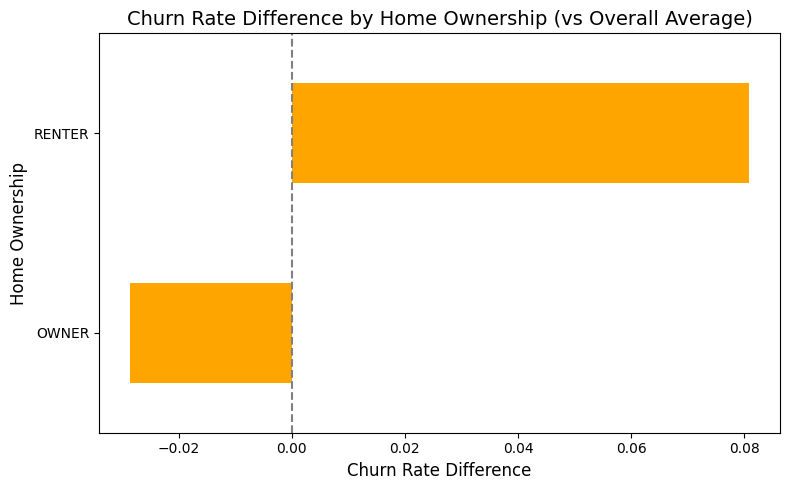

In [261]:
print(newspaper_df.groupby('Home Ownership')['is_churned'].agg(['mean', 'count']))

# 전체 평균 이탈률
avg_churn_rate = newspaper_df['is_churned'].mean()
print(avg_churn_rate)

# 각 Home Ownership 범주별 이탈률
group_churn_rate = newspaper_df.groupby('Home Ownership')['is_churned'].mean()
print(group_churn_rate)

# 이탈률 차이 계산 (범주별 이탈률 - 전체 평균 이탈률)
churn_rate_diff = group_churn_rate - avg_churn_rate

# 시각화
plt.figure(figsize=(8, 5))
churn_rate_diff.sort_values().plot(kind='barh', color='orange')

# 기준선(0)
plt.axvline(0, color='gray', linestyle='--')

# 제목 및 라벨 설정
plt.title("Churn Rate Difference by Home Ownership (vs Overall Average)", fontsize=14)
plt.xlabel("Churn Rate Difference", fontsize=12)
plt.ylabel("Home Ownership", fontsize=12)
plt.tight_layout()
plt.show()

In [262]:
chi2_test_on_category(newspaper_df, 'Home Ownership')

Category: Home Ownership
Chi2 statistic: 227.2742
Degrees of freedom: 1
P-value: 2.3432e-51
Cramér's V (effect size): 0.1213
=> 통계적으로 유의미한 관련성이 있습니다.



## Ethnicity & Language 별 이탈(잔류) 카운트

- 민족, 사용 언어별 이탈과 잔류 수 히스토그램 비교
- 평균 이탈률 대비 민족별 및 사용 언어별 이탈률 차이 비교
- 카이제곱 검정을 통한 민족별 및 사용 언어별 이탈률의 독립 여부 평가

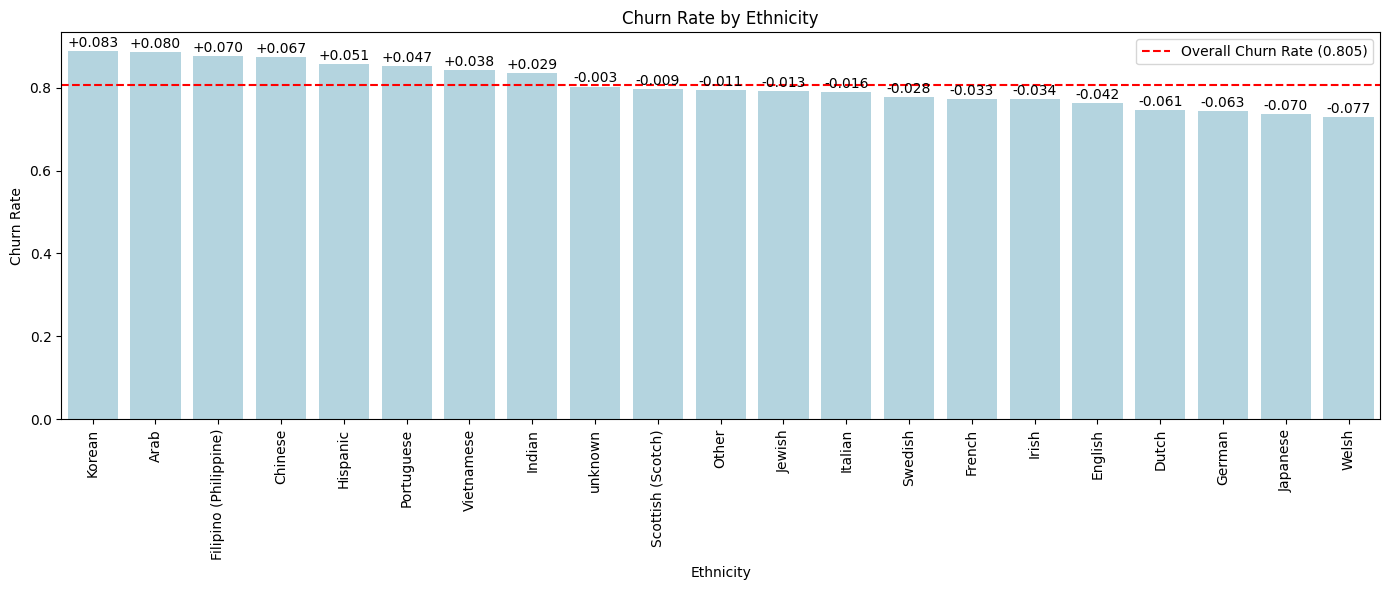

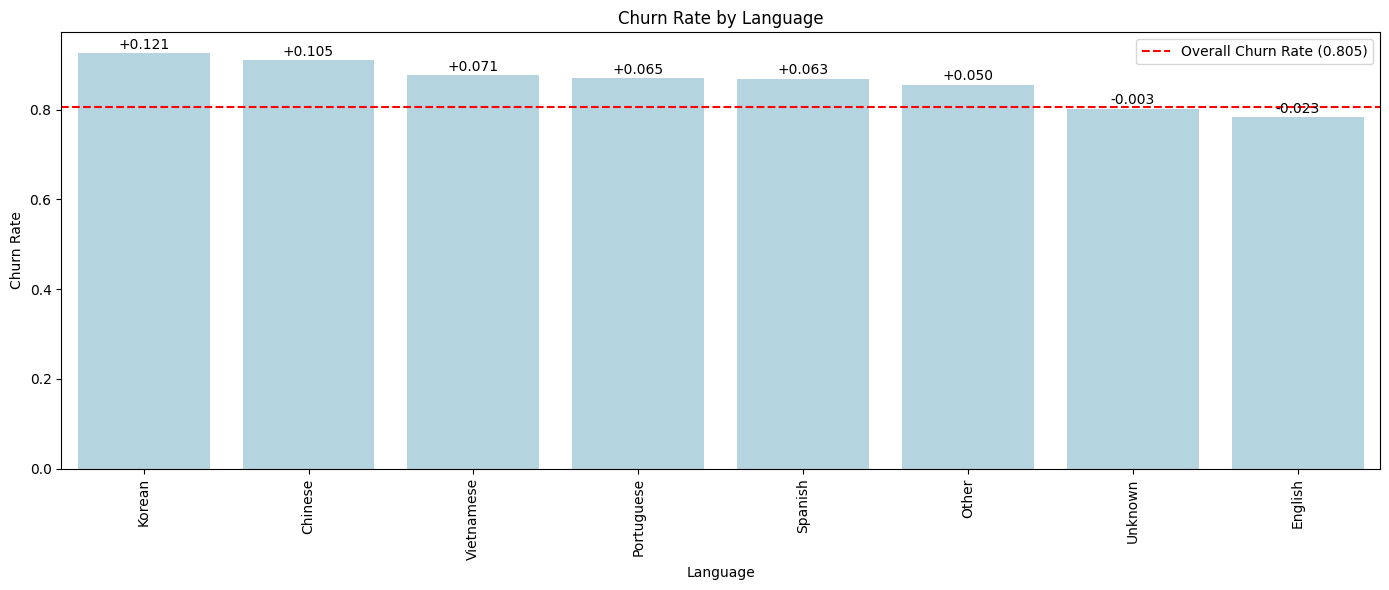

In [263]:
# Ethnicity에서 적은 범주 'Other'로 묶기
df_ethnicity_grouped = group_low_freq_categories(newspaper_df, 'Ethnicity', min_count_threshold)
plot_churn_rate_difference(df_ethnicity_grouped, 'Ethnicity', 'Churn Rate by Ethnicity')

# Language에서 적은 범주 'Other'로 묶기
df_language_grouped = group_low_freq_categories(newspaper_df, 'Language', min_count_threshold)
plot_churn_rate_difference(df_language_grouped, 'Language', 'Churn Rate by Language')

In [264]:
# Ethnicity 필터링
df_ethnicity_filtered = filter_low_freq_categories(newspaper_df, 'Ethnicity', threshold=100)
chi2_test_on_category(df_ethnicity_filtered, 'Ethnicity')

# Language 필터링
df_language_filtered = filter_low_freq_categories(newspaper_df, 'Language', threshold=100)
chi2_test_on_category(df_language_filtered, 'Language')

Category: Ethnicity
Chi2 statistic: 197.2753
Degrees of freedom: 19
P-value: 1.1848e-31
Cramér's V (effect size): 0.1164
=> 통계적으로 유의미한 관련성이 있습니다.

Category: Language
Chi2 statistic: 136.1152
Degrees of freedom: 6
P-value: 6.6138e-27
Cramér's V (effect size): 0.0953
=> 통계적으로 유의미한 관련성이 있습니다.



## Age range 별 이탈(잔류) 카운트

- 나이별 이탈과 잔류 수 히스토그램 비교
- 평균 이탈률 대비 나이별 이탈률 차이 비교
- 카이제곱 검정을 통한 나이별 이탈률의 독립 여부 평가

In [265]:
newspaper_df['Age range'].value_counts()

Age range
50-54               1883
45-49               1833
55-59               1756
75 years or more    1674
60-64               1441
40-44               1255
65-69               1184
35-39               1102
30-34               1062
70-74                937
25-29                838
24 years or less     473
Name: count, dtype: int64

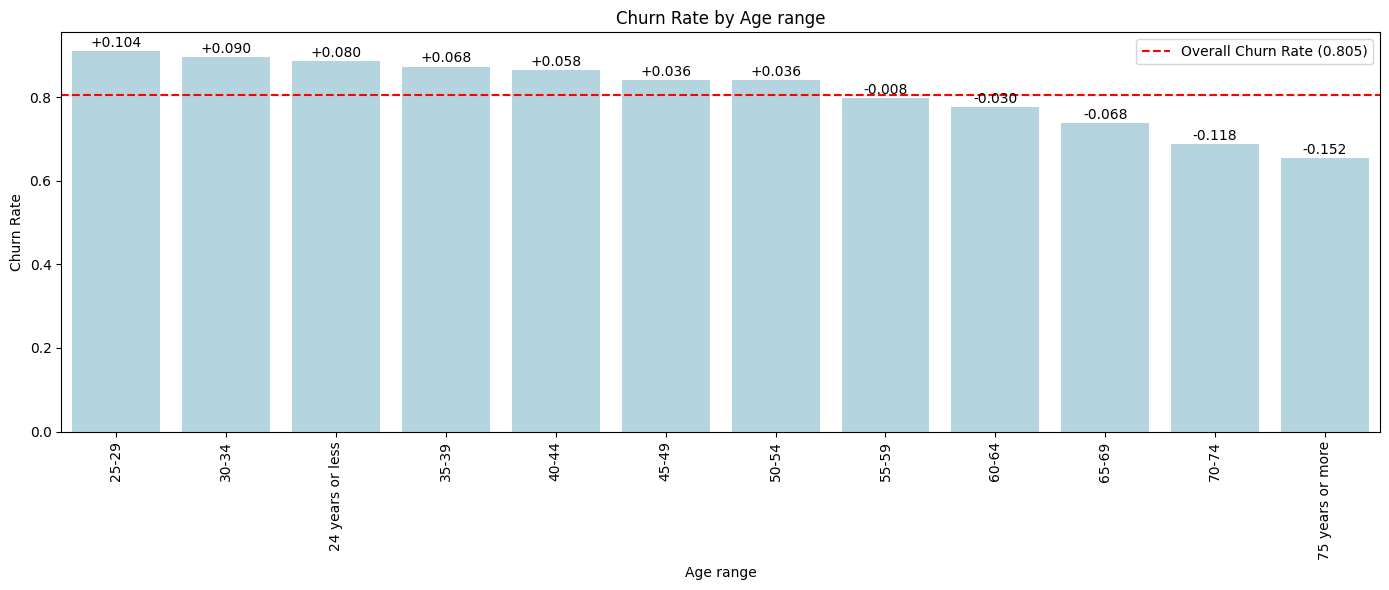

In [266]:
# Age range 적은 범주 'Other'로 묶기
df_age_grouped = group_low_freq_categories(newspaper_df, 'Age range', min_count_threshold)
plot_churn_rate_difference(df_age_grouped, 'Age range', 'Churn Rate by Age range')

In [267]:
# age 필터링
df_age_filtered = filter_low_freq_categories(newspaper_df, 'Age range', threshold=100)
chi2_test_on_category(df_age_filtered, 'Age range')

Category: Age range
Chi2 statistic: 595.4735
Degrees of freedom: 11
P-value: 1.3018e-120
Cramér's V (effect size): 0.1964
=> 통계적으로 유의미한 관련성이 있습니다.



## 소득 별 이탈(잔류) 카운트

- 소득별 이탈과 잔류 수 히스토그램 비교
- 평균 이탈률 대비 소득별 이탈률 차이 비교
- 카이제곱 검정을 통한 소득별 이탈률의 독립 여부 평가

In [268]:
newspaper_df['HH Income'].value_counts()

HH Income
Under $20,000          1867
$100,000 - $124,999    1720
$125,000 - $149,999    1331
$  20,000 - $29,999    1119
$  40,000 - $49,999    1062
$  30,000 - $39,999     888
$  70,000 - $79,999     855
$  50,000 - $59,999     853
$150,000 - $174,999     851
$  80,000 - $89,999     840
$  90,000 - $99,999     822
$  60,000 - $69,999     820
$300,000 - $399,999     807
$175,000 - $199,999     606
$200,000 - $249,999     501
$400,000 - $499,999     255
$500,000 Plus           223
$250,000 - $299,999      18
Name: count, dtype: int64

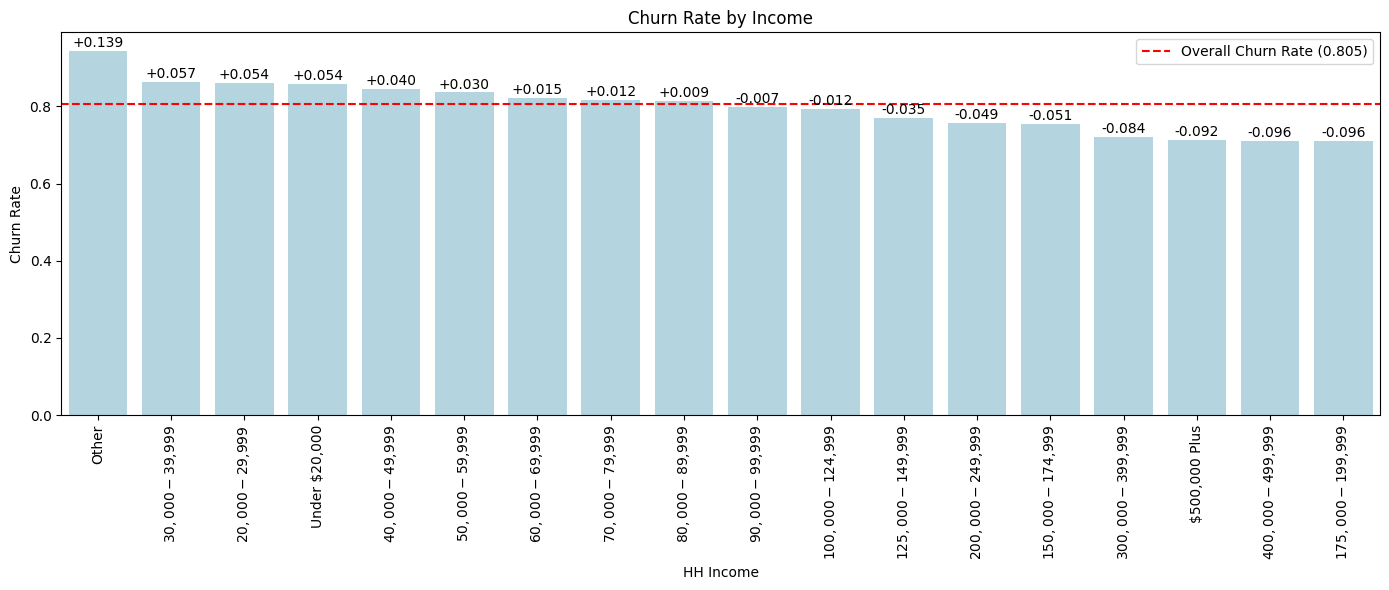

In [269]:
df_income_grouped = group_low_freq_categories(newspaper_df, 'HH Income', min_count_threshold)
plot_churn_rate_difference(df_income_grouped, 'HH Income', 'Churn Rate by Income')

In [270]:
df_income_filtered = filter_low_freq_categories(newspaper_df, 'HH Income', threshold=100)
chi2_test_on_category(df_income_filtered, 'HH Income')

Category: HH Income
Chi2 statistic: 225.6518
Degrees of freedom: 16
P-value: 4.9239e-39
Cramér's V (effect size): 0.1210
=> 통계적으로 유의미한 관련성이 있습니다.



## Source Channel 별 이탈(잔류) 카운트
- Source Channel별 이탈과 잔류 수 히스토그램 비교
- 평균 이탈률 대비 Source Channel별 이탈률 차이 비교
- 카이제곱 검정을 통한 Source Channel별 이탈률의 독립 여부 평가

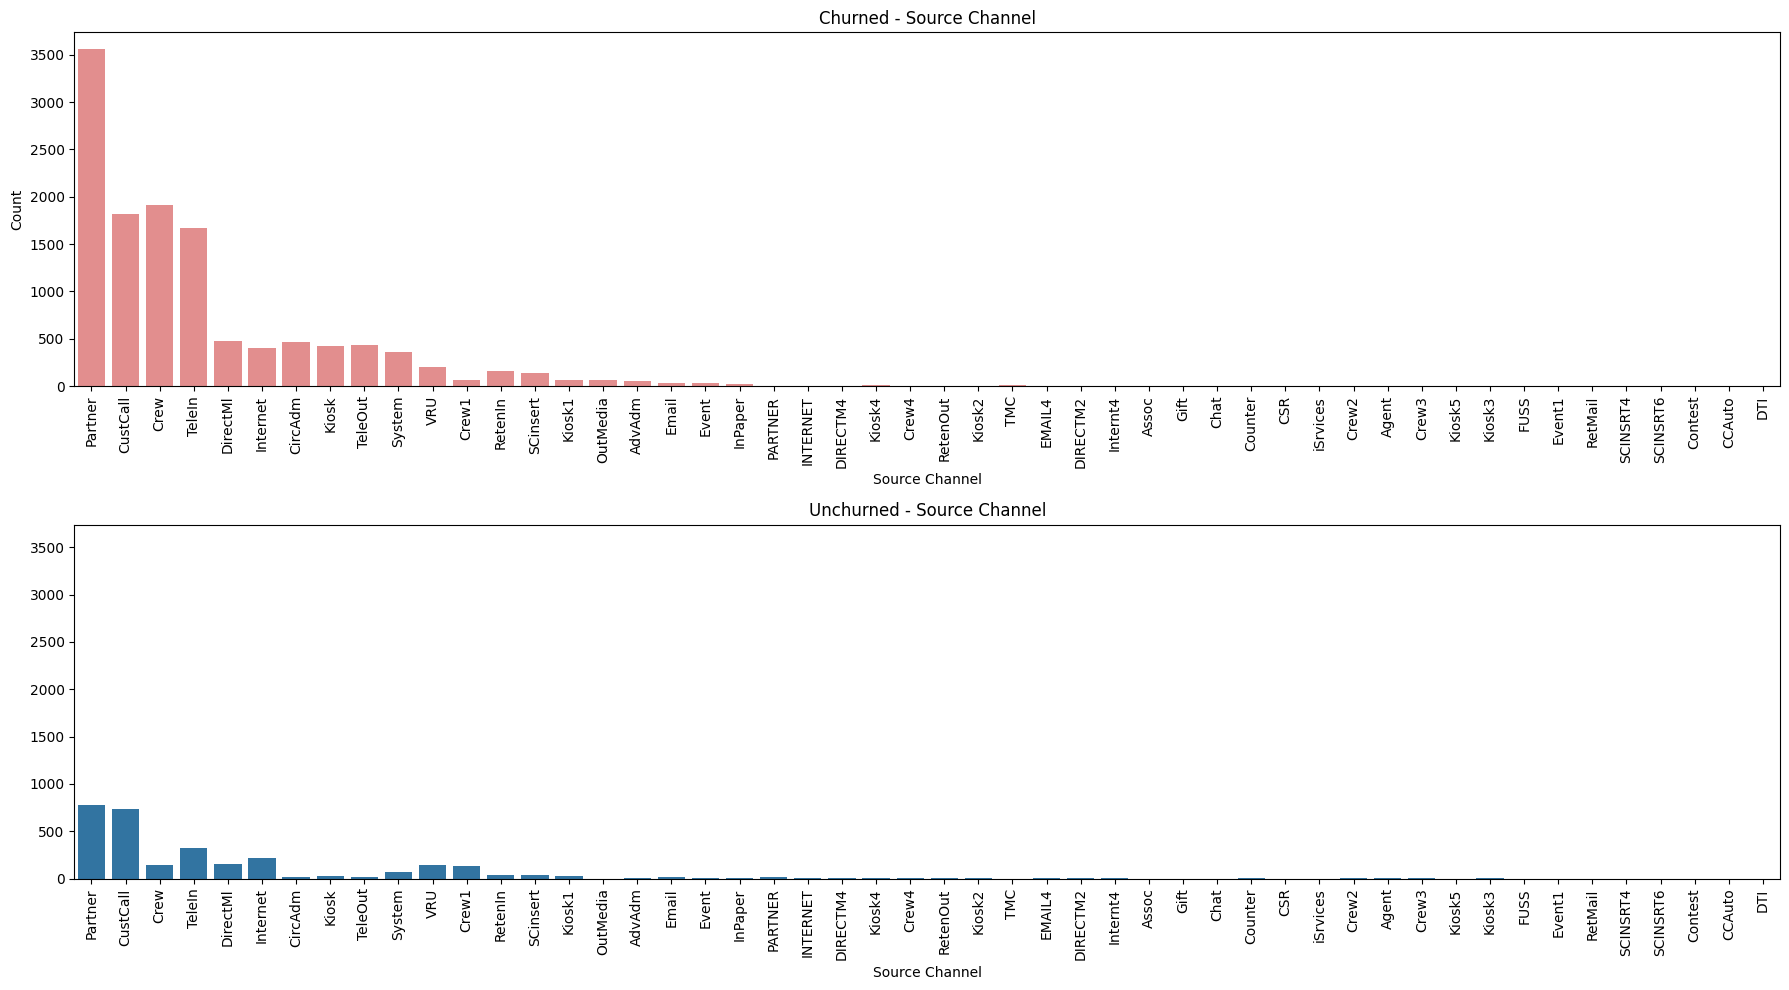

In [271]:
# 1. Source Channel - Bar plots
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharey=True)
sns.countplot(x='Source Channel', data=newspaper_df[newspaper_df['is_churned'] == 1],
              order=newspaper_df['Source Channel'].value_counts().index, ax=axes[0], color='lightcoral')
axes[0].set_title('Churned - Source Channel')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

sns.countplot(x='Source Channel', data=newspaper_df[newspaper_df['is_churned'] == 0],
              order=newspaper_df['Source Channel'].value_counts().index, ax=axes[1])
axes[1].set_title('Unchurned - Source Channel')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


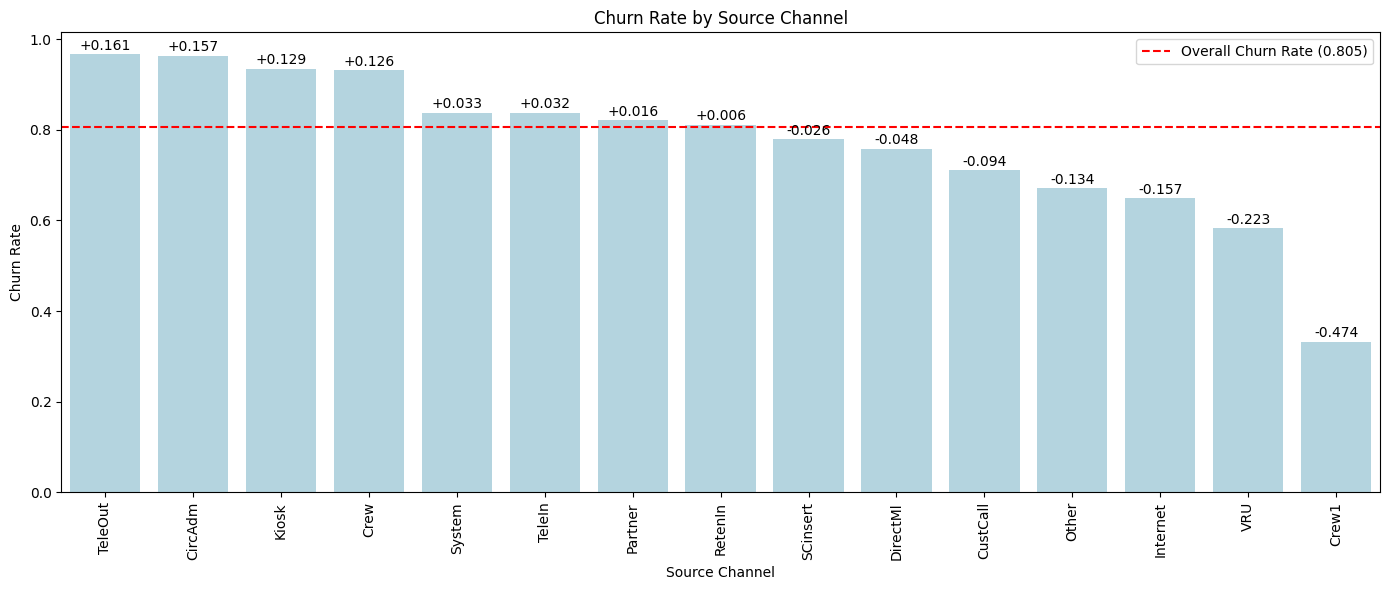

In [272]:
df_source_grouped = group_low_freq_categories(newspaper_df, 'Source Channel', min_count_threshold)
plot_churn_rate_difference(df_source_grouped, 'Source Channel', 'Churn Rate by Source Channel')

In [273]:
df_source_grouped = group_low_freq_categories(newspaper_df, 'Source Channel', 100)
chi2_test_on_category(df_source_grouped, 'Source Channel')

Category: Source Channel
Chi2 statistic: 1134.0203
Degrees of freedom: 14
P-value: 2.6269e-233
Cramér's V (effect size): 0.2710
=> 통계적으로 유의미한 관련성이 있습니다.



## Delivery Period 별 이탈(잔류) 카운트

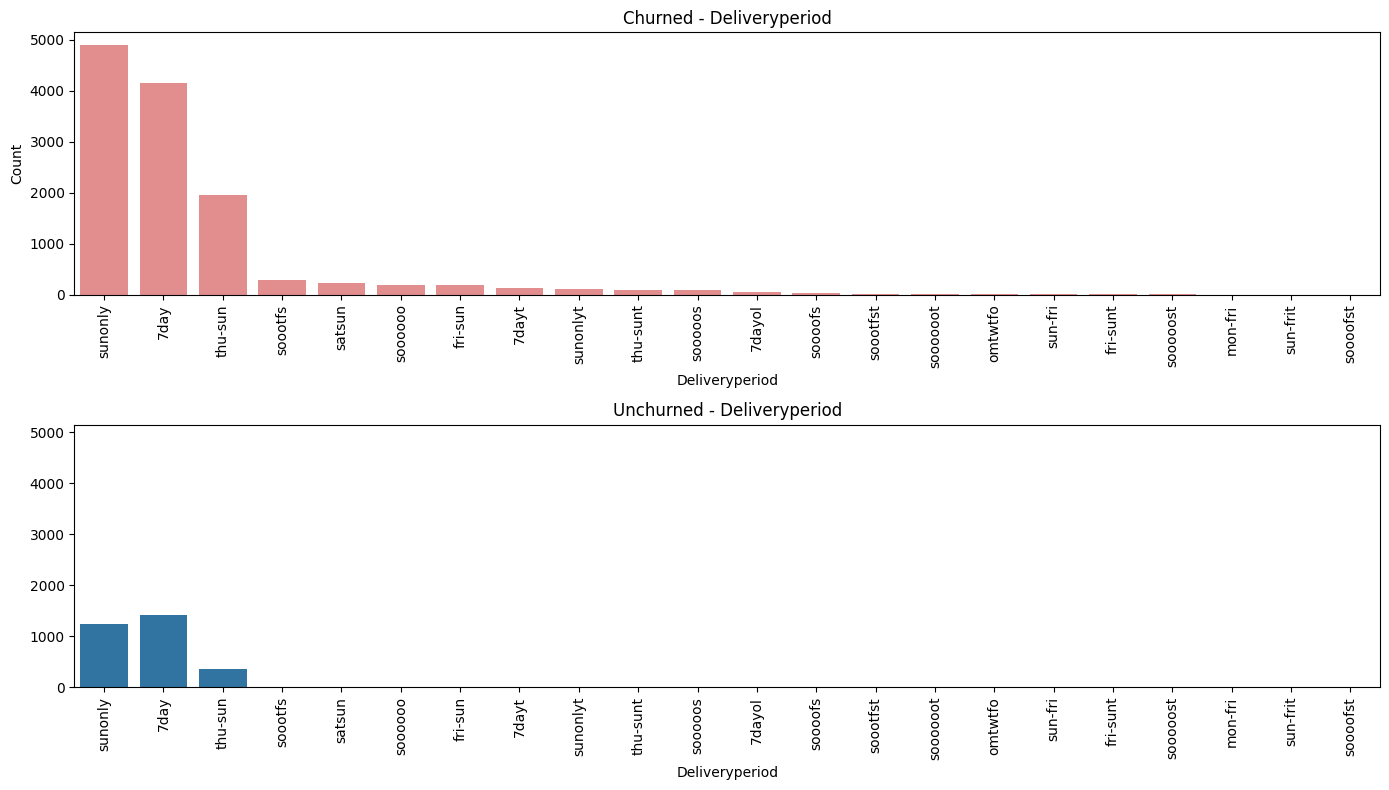

In [274]:
# 2. Deliveryperiod - Bar plots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharey=True)
sns.countplot(x='Deliveryperiod', data=newspaper_df[newspaper_df['is_churned'] == 1],
              order=newspaper_df['Deliveryperiod'].value_counts().index, ax=axes[0], color='lightcoral')
axes[0].set_title('Churned - Deliveryperiod')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

sns.countplot(x='Deliveryperiod', data=newspaper_df[newspaper_df['is_churned'] == 0],
              order=newspaper_df['Deliveryperiod'].value_counts().index, ax=axes[1])
axes[1].set_title('Unchurned - Deliveryperiod')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

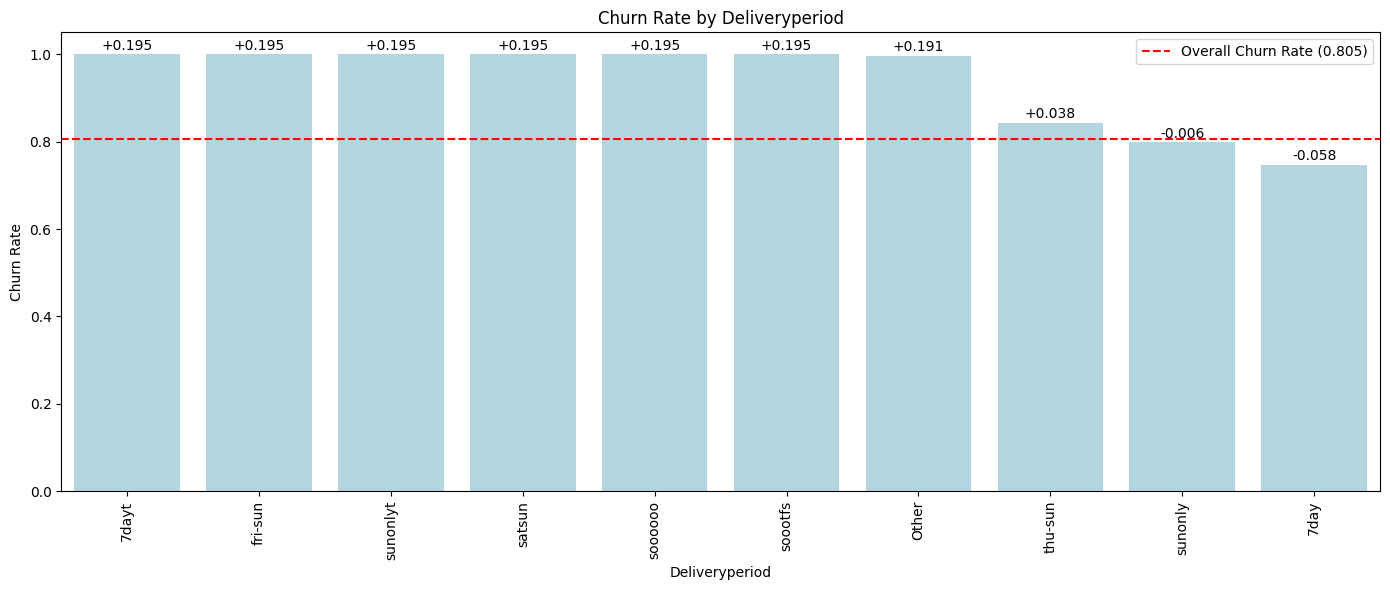

In [275]:
df_delivery_grouped = group_low_freq_categories(newspaper_df, 'Deliveryperiod', min_count_threshold)
plot_churn_rate_difference(df_delivery_grouped, 'Deliveryperiod', 'Churn Rate by Deliveryperiod')

In [276]:
df_source_grouped = group_low_freq_categories(newspaper_df, 'Deliveryperiod', 100)
chi2_test_on_category(df_source_grouped, 'Deliveryperiod')

Category: Deliveryperiod
Chi2 statistic: 484.2612
Degrees of freedom: 9
P-value: 1.3454e-98
Cramér's V (effect size): 0.1771
=> 통계적으로 유의미한 관련성이 있습니다.



## 이탈 여부 별 Dummy for Children 유무 비율
- 두 범주 간에 이탈률과의 관련성이 없음
- 나이와 소득으로 분해해서 비교해도 관련성이 없음

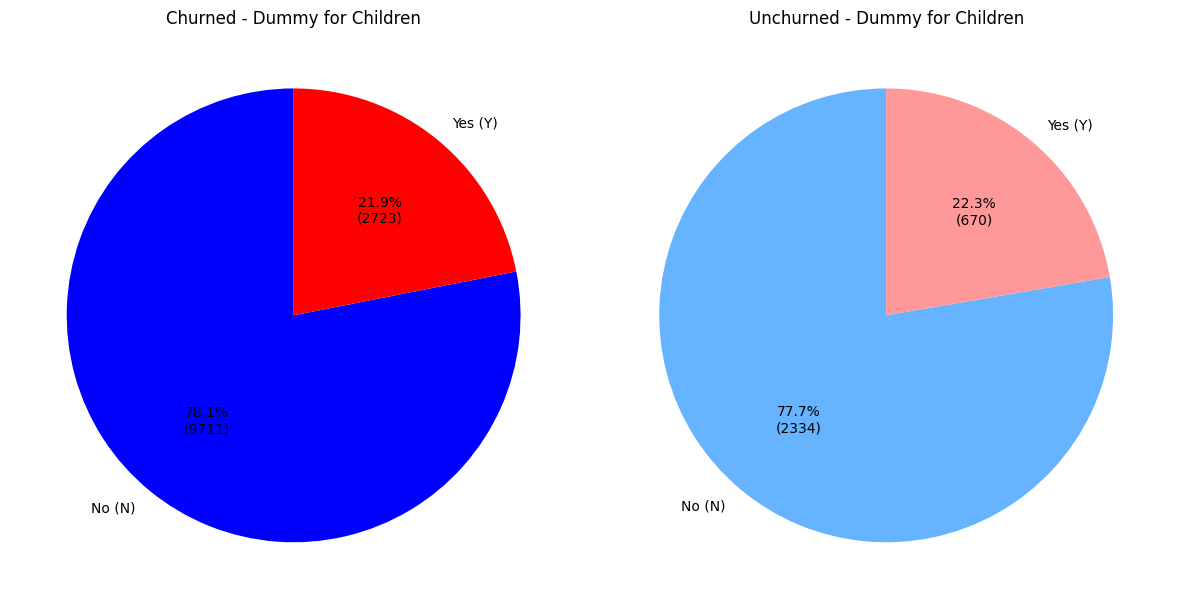

In [277]:
import matplotlib.pyplot as plt

# Map 0/1 to readable labels
label_map = {"N": "No (N)", "Y": "Yes (Y)"}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Churned
counts_churned = newspaper_df[newspaper_df['is_churned'] == 1]['dummy for Children'].value_counts().sort_index()
labels_churned = [label_map[i] for i in counts_churned.index]
axes[0].pie(counts_churned,
            labels=labels_churned,
            autopct=lambda p: f'{p:.1f}%\n({int(round(p*sum(counts_churned)/100))})',
            startangle=90,
            colors=['blue', 'red'])
axes[0].set_title('Churned - Dummy for Children')

# Unchurned
counts_unchurned = newspaper_df[newspaper_df['is_churned'] == 0]['dummy for Children'].value_counts().sort_index()
labels_unchurned = [label_map[i] for i in counts_unchurned.index]
axes[1].pie(counts_unchurned,
            labels=labels_unchurned,
            autopct=lambda p: f'{p:.1f}%\n({int(round(p*sum(counts_unchurned)/100))})',
            startangle=90,
            colors=['#66b3ff', '#ff9999'])
axes[1].set_title('Unchurned - Dummy for Children')

plt.tight_layout()
plt.show()

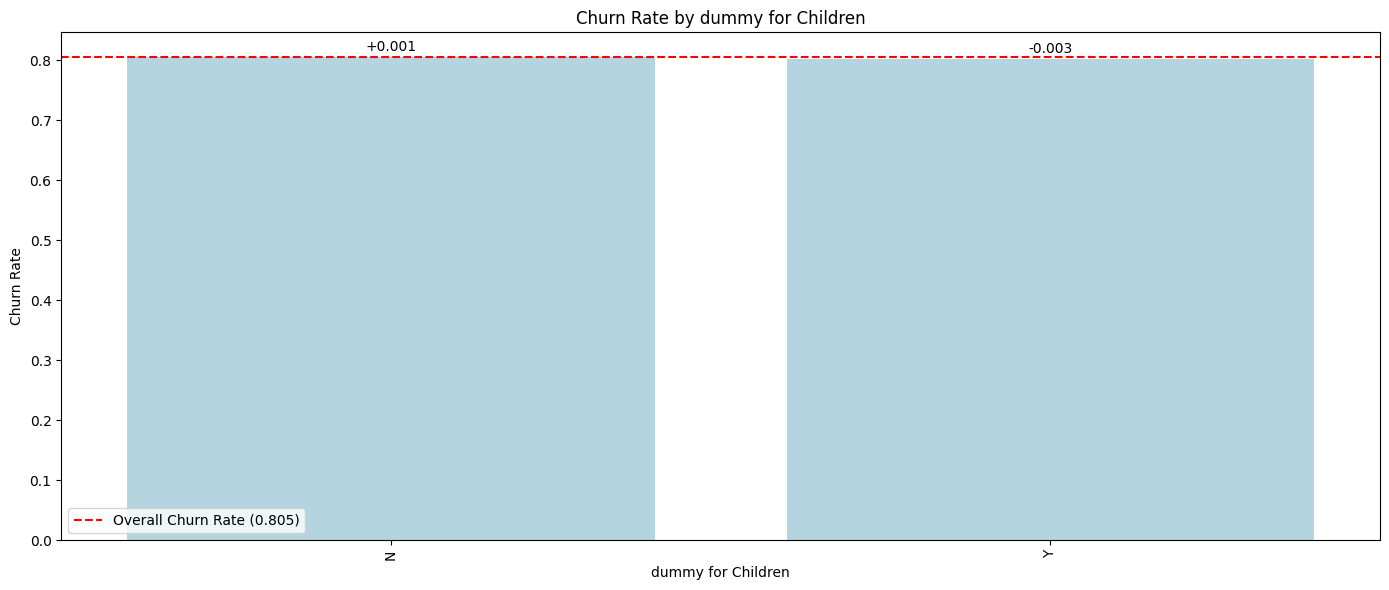

In [278]:
df_children_grouped = group_low_freq_categories(newspaper_df, 'dummy for Children', min_count_threshold)
plot_churn_rate_difference(df_children_grouped, 'dummy for Children', 'Churn Rate by dummy for Children')

In [279]:
df_children_grouped = group_low_freq_categories(newspaper_df, 'dummy for Children', 100)
chi2_test_on_category(df_children_grouped, 'dummy for Children')

Category: dummy for Children
Chi2 statistic: 0.2073
Degrees of freedom: 1
P-value: 6.4890e-01
Cramér's V (effect size): 0.0037
=> 통계적으로 유의미한 관련성이 없습니다.



- 다른 변수들과 뜯어보기

In [280]:
newspaper_df.columns.to_list()

['HH Income',
 'Home Ownership',
 'Ethnicity',
 'dummy for Children',
 'Year Of Residence',
 'Age range',
 'Language',
 'City',
 'County',
 'weekly fee',
 'Deliveryperiod',
 'Nielsen Prizm',
 'reward program',
 'Source Channel',
 'is_churned']

Chi-square test for dummy for Children × Age range
Chi2 = 620.9227, p-value = 1.8784e-116, dof = 23
➡ 유의미한 차이가 있음 (p < 0.05)



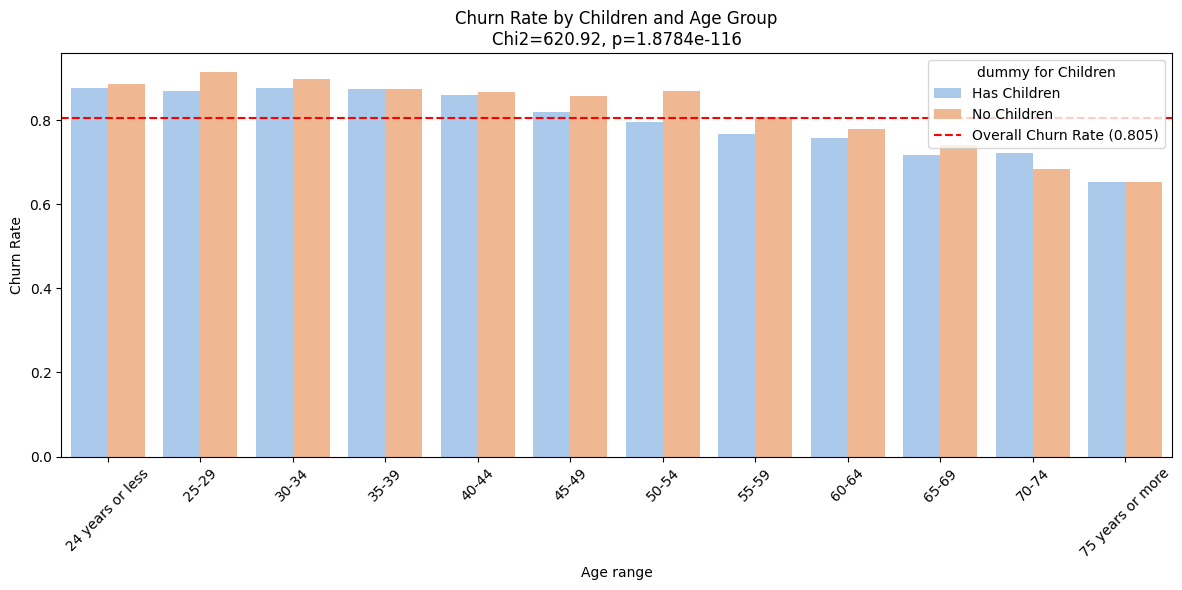

Chi-square test for dummy for Children × HH Income
Chi2 = 260.7112, p-value = 2.5852e-36, dof = 35
➡ 유의미한 차이가 있음 (p < 0.05)



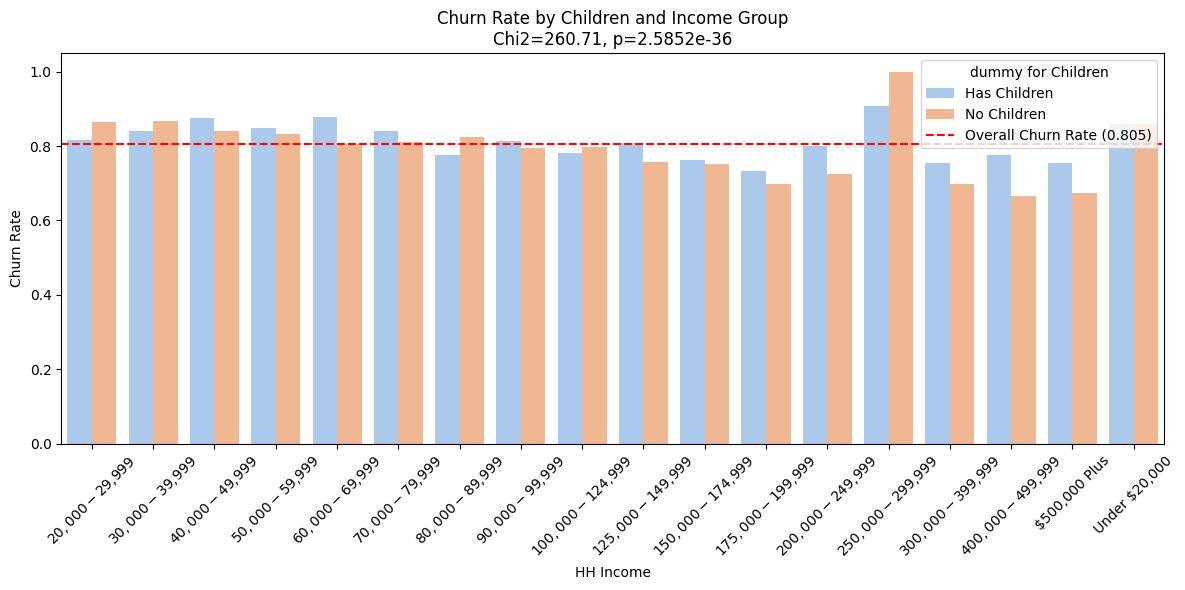

In [281]:
def plot_churn_rate_by_two_cats(df, cat1, cat2, cat1_label_map=None, cat2_label_map=None, title=''):
    df_plot = df.copy()
    if cat1_label_map is not None:
        df_plot[cat1] = df_plot[cat1].map(cat1_label_map)
    if cat2_label_map is not None:
        df_plot[cat2] = df_plot[cat2].map(cat2_label_map)

    overall_churn_rate = df_plot['is_churned'].mean()
    
    # 그룹별 이탈률 계산
    grouped = df_plot.groupby([cat1, cat2])['is_churned'].agg(['mean', 'count']).reset_index()
    grouped.rename(columns={'mean': 'Churn Rate', 'count': 'Count'}, inplace=True)
    grouped['Diff from Mean'] = grouped['Churn Rate'] - overall_churn_rate

    # --- 카이제곱 검정 ---
    contingency_table = pd.crosstab(index=[df_plot[cat1], df_plot[cat2]], columns=df_plot['is_churned'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {cat1} × {cat2}")
    print(f"Chi2 = {chi2:.4f}, p-value = {p:.4e}, dof = {dof}")
    if p < 0.05:
        print("➡ 유의미한 차이가 있음 (p < 0.05)")
    else:
        print("➡ 유의미한 차이 없음 (p >= 0.05)")
    print()

    # 시각화
    plt.figure(figsize=(12,6))
    sns.barplot(data=grouped, x=cat2, y='Churn Rate', hue=cat1, palette='pastel')
    plt.axhline(overall_churn_rate, color='red', linestyle='--', 
                label=f'Overall Churn Rate ({overall_churn_rate:.3f})')
    plt.title(f"{title}\nChi2={chi2:.2f}, p={p:.4e}")
    plt.ylabel('Churn Rate')
    plt.xlabel(cat2)
    plt.legend(title=cat1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_churn_rate_by_two_cats(
newspaper_df, 
'dummy for Children', 
'Age range',
cat1_label_map={"N": "No Children", "Y": "Has Children"},
title='Churn Rate by Children and Age Group'
)

plot_churn_rate_by_two_cats(
    newspaper_df, 
    'dummy for Children', 
    'HH Income',
    cat1_label_map={"N": "No Children", "Y": "Has Children"},
    title='Churn Rate by Children and Income Group'
)

## 이탈 여부 별 도시 비율

In [282]:
newspaper_df['City'].unique()

array(['LONG BEACH', 'NEWPORT COAST', 'IRVINE', 'LAGUNA NIGUEL',
       'RANCHO SANTA MARGARITA', 'LADERA RANCH', 'SAN CLEMENTE',
       'BUENA PARK', 'ALISO VIEJO', 'LAGUNA WOODS', 'NEWPORT BEACH',
       'FOOTHILL RANCH', 'TRABUCO CANYON', 'DANA POINT', 'LAGUNA HILLS',
       'LAGUNA BEACH', 'ANAHEIM', 'SANTA ANA', 'FULLERTON', 'LA HABRA',
       'COSTA MESA', 'HUNTINGTON BEACH', 'CYPRESS', 'GARDEN GROVE',
       'CORONA', 'BREA', 'WESTMINSTER', 'WHITTIER', 'FOUNTAIN VALLEY',
       'PLACENTIA', 'VILLA PARK', 'ORANGE', 'TUSTIN', 'STANTON', 'NORCO',
       'LOS ALAMITOS', 'MISSION VIEJO', 'CERRITOS', 'DIAMOND BAR',
       'CORONA DEL MAR', 'SEAL BEACH', 'LAKEWOOD', 'ARTESIA', 'CHINO',
       'LA MIRADA', 'HAWAIIAN GARDENS', 'CHINO HILLS', 'MIDWAY CITY',
       'YORBA LINDA', 'SIGNAL HILL', 'LAKE FOREST', 'SILVERADO',
       'SAN JUAN CAPISTRANO', 'CAPISTRANO BEACH', 'MURRIETA', 'LA PALMA'],
      dtype=object)

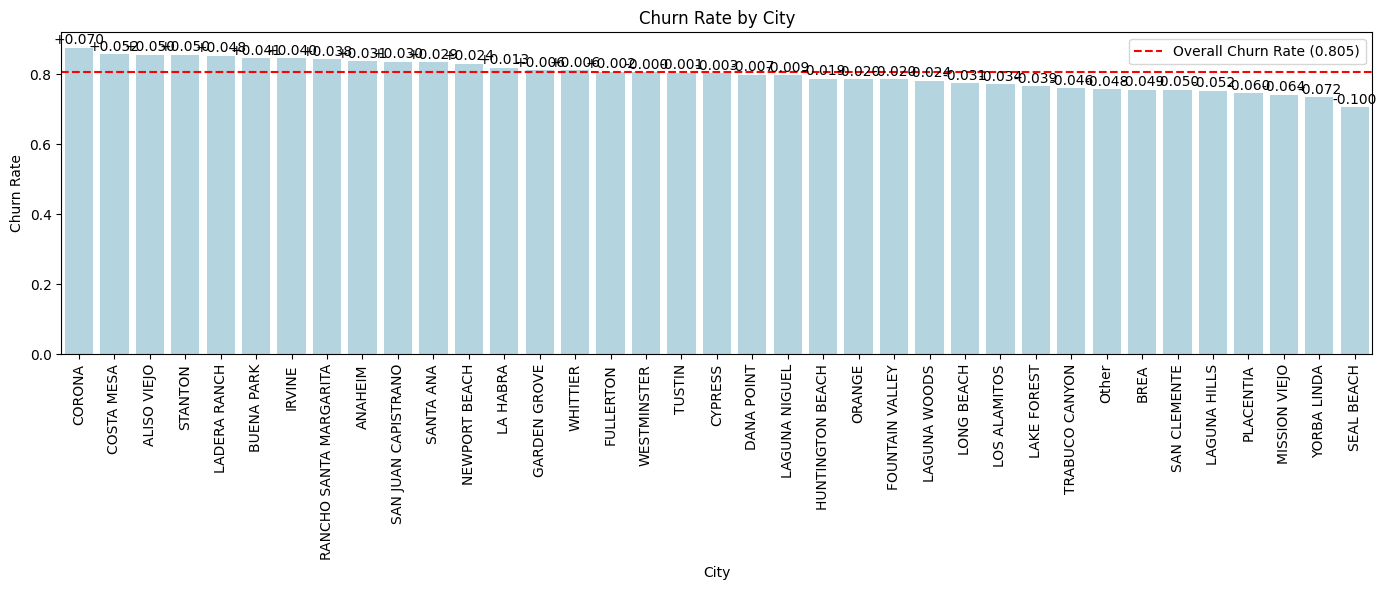

In [283]:
df_city_grouped = group_low_freq_categories(newspaper_df, 'City', min_count_threshold)
plot_churn_rate_difference(df_city_grouped, 'City', 'Churn Rate by City')

In [284]:
df_city_grouped = group_low_freq_categories(newspaper_df, 'City', 100)
chi2_test_on_category(df_city_grouped, 'City')

Category: City
Chi2 statistic: 143.3376
Degrees of freedom: 36
P-value: 9.5371e-15
Cramér's V (effect size): 0.0964
=> 통계적으로 유의미한 관련성이 있습니다.



In [285]:
newspaper_df['County'].unique()

array(['LOS ANGELES', 'ORANGE', 'RIVERSIDE', 'SAN BERNARDINO'],
      dtype=object)

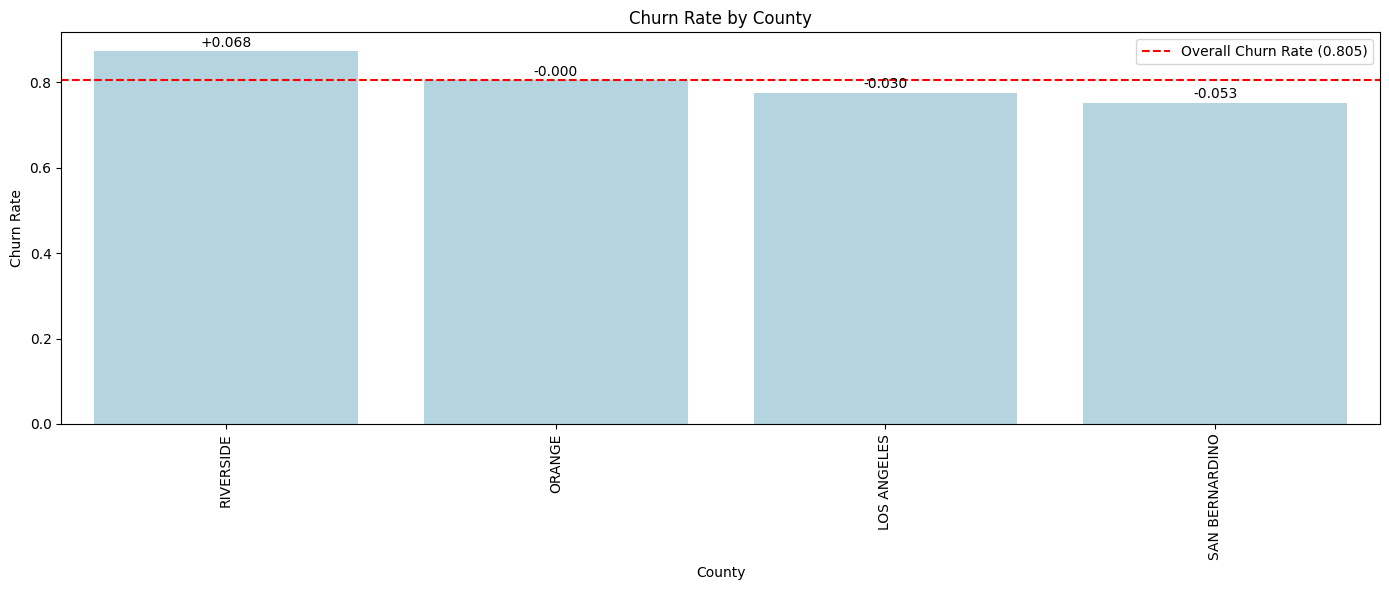

In [286]:
df_county_grouped = group_low_freq_categories(newspaper_df, 'County', min_count_threshold)
plot_churn_rate_difference(df_county_grouped, 'County', 'Churn Rate by County')

In [287]:
df_county_grouped = group_low_freq_categories(newspaper_df, 'County', 100)
chi2_test_on_category(df_county_grouped, 'County')

Category: County
Chi2 statistic: 19.9814
Degrees of freedom: 3
P-value: 1.7125e-04
Cramér's V (effect size): 0.0360
=> 통계적으로 유의미한 관련성이 있습니다.



#### weekly fee 분석

In [288]:
newspaper_df.columns.to_list()

['HH Income',
 'Home Ownership',
 'Ethnicity',
 'dummy for Children',
 'Year Of Residence',
 'Age range',
 'Language',
 'City',
 'County',
 'weekly fee',
 'Deliveryperiod',
 'Nielsen Prizm',
 'reward program',
 'Source Channel',
 'is_churned']

In [289]:
newspaper_df['weekly fee'].unique()

array(['$7.00 - $7.99', '$0.01 - $0.50', '$1.00 - $1.99', '$8.00 - $8.99',
       '$0 - $0.01', '$2.00 - $2.99', '$9.00 - $9.99', '$4.00 - $4.99',
       '$0.51 - $0.99', '$3.00 - $3.99', '$5.00 - $5.99', '$6.00 - $6.99',
       '$10.00 - $10.99', '$0'], dtype=object)

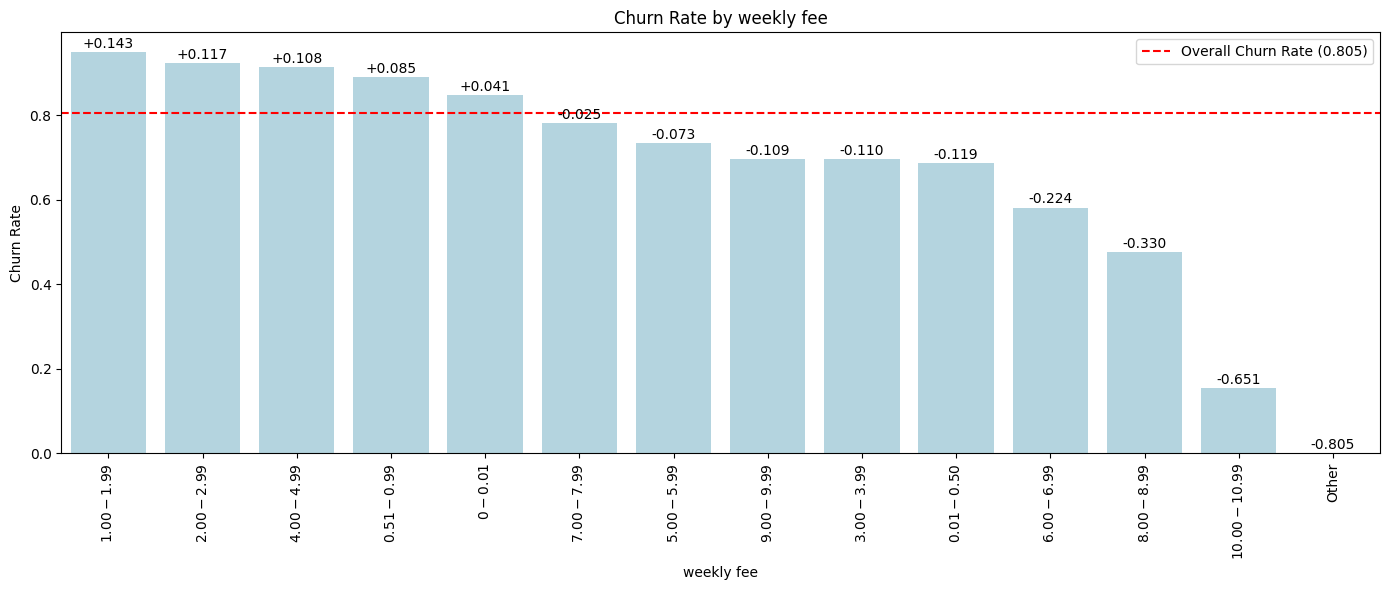

In [290]:
df_fee_grouped = group_low_freq_categories(newspaper_df, 'weekly fee', min_count_threshold)
plot_churn_rate_difference(df_fee_grouped, 'weekly fee', 'Churn Rate by weekly fee')

In [291]:
df_fee_grouped = group_low_freq_categories(newspaper_df, 'weekly fee', 100)
chi2_test_on_category(df_fee_grouped, 'weekly fee')

Category: weekly fee
Chi2 statistic: 2637.6386
Degrees of freedom: 13
P-value: 0.0000e+00
Cramér's V (effect size): 0.4133
=> 통계적으로 유의미한 관련성이 있습니다.



#### Nielsen Prizm 분석

In [292]:
newspaper_df['Nielsen Prizm'].unique()

array(['FM', 'MW', 'MM', 'FW', 'YW', 'YM', 'ME', 'YE', 'FE'], dtype=object)

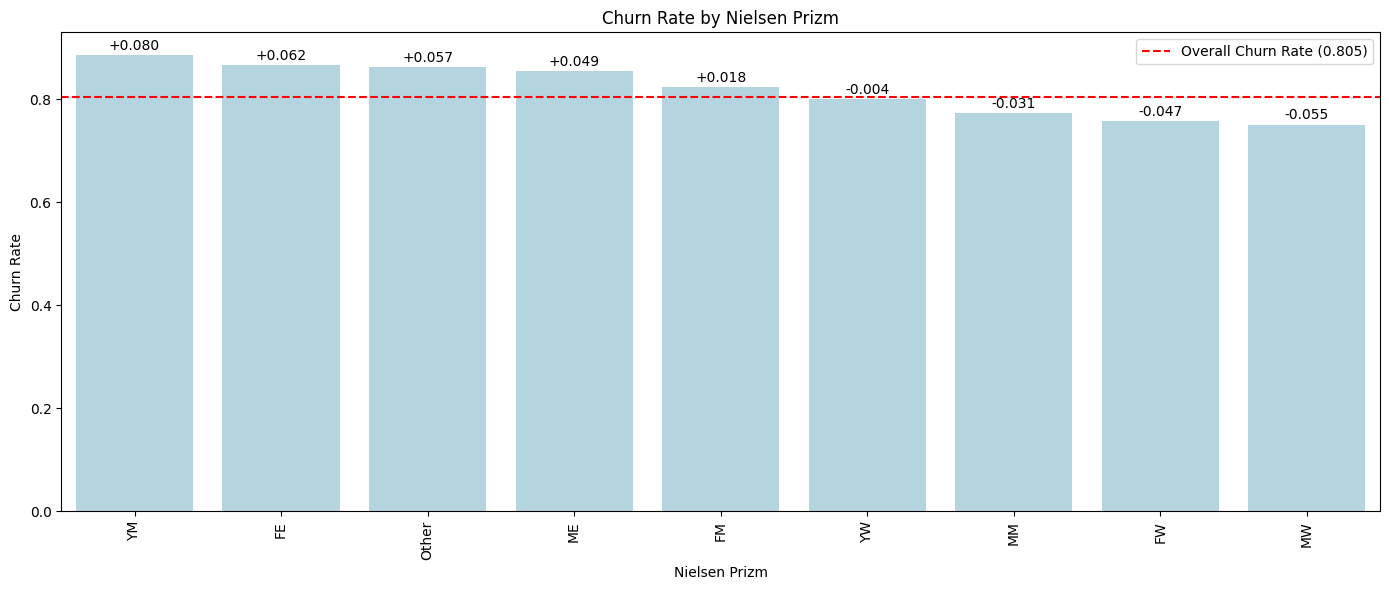

In [293]:
df_prizm_grouped = group_low_freq_categories(newspaper_df, 'Nielsen Prizm', min_count_threshold)
plot_churn_rate_difference(df_prizm_grouped, 'Nielsen Prizm', 'Churn Rate by Nielsen Prizm')

In [294]:
df_prizm_grouped = group_low_freq_categories(newspaper_df, 'Nielsen Prizm', 100)
chi2_test_on_category(df_prizm_grouped, 'Nielsen Prizm')

Category: Nielsen Prizm
Chi2 statistic: 243.8868
Degrees of freedom: 8
P-value: 3.4017e-48
Cramér's V (effect size): 0.1257
=> 통계적으로 유의미한 관련성이 있습니다.



## 이탈 여부 별 거주기간, 보상 프로그램 획득 count/분포
- 각 수치형 변수 간의 이탈, 잔류에 따른 개별 분포 확인
- 하지만 개별 분포로는 이탈률과의 관계를 알기 어렵기 때문에 결국 이탈률과의 관계를 위해 다시 범주를 나눠서 범주별 이탈률을 비교

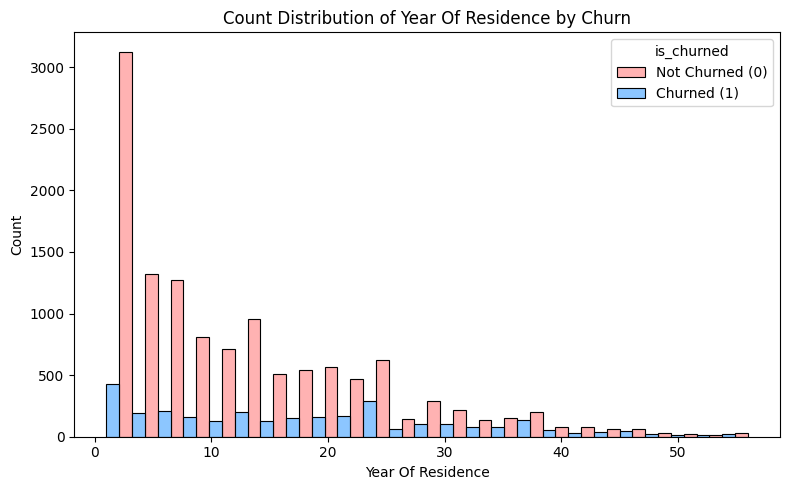

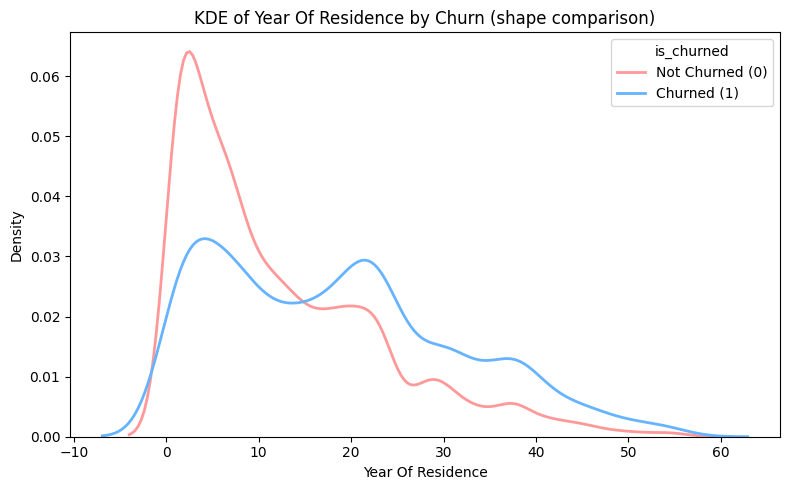

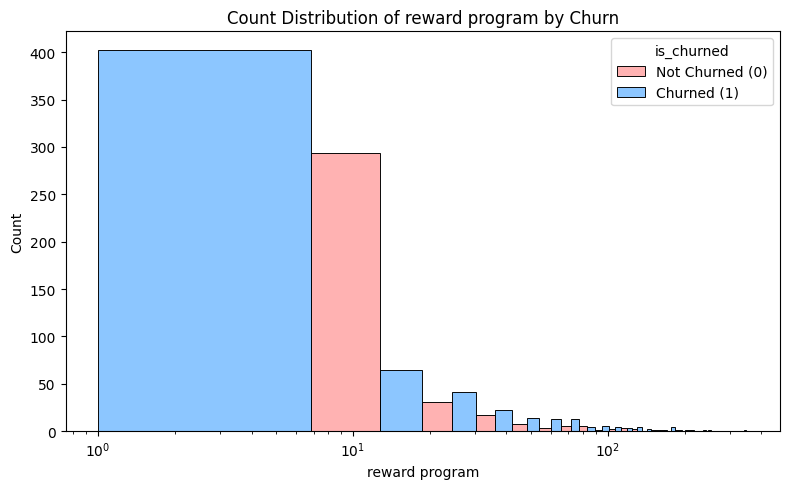

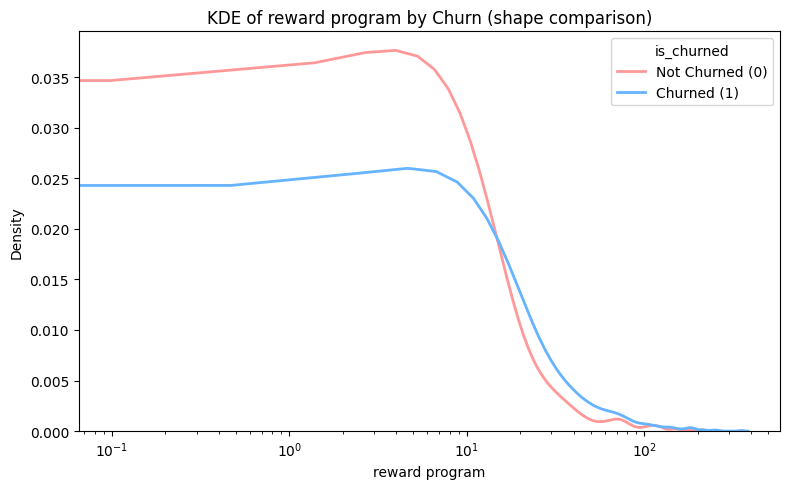

In [295]:
def hist_by_churn(df, col, bins=30, log_x=False):
    data = df[[col, 'is_churned']].dropna()
    # shared bins for fair comparison
    x = data[col].values
    if log_x:
        x = np.where(x <= 0, np.nan, x)  # guard for non-positive when log
        data = data.loc[~np.isnan(x)]
    bin_edges = np.linspace(data[col].min(), data[col].max(), bins+1)

    plt.figure(figsize=(8,5))
    sns.histplot(
        data=data,
        x=col,
        hue='is_churned',
        bins=bin_edges,
        multiple='dodge',   # use 'stack' if you prefer stacked counts
        edgecolor='black',
        palette={0:'#66b3ff', 1:'#ff9999'}
    )
    if log_x:
        plt.xscale('log')
        plt.xlabel(f'{col} (log scale)')
    plt.title(f'Count Distribution of {col} by Churn')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.legend(title='is_churned', labels=['Not Churned (0)', 'Churned (1)'])
    plt.tight_layout()
    plt.show()

def kde_by_churn(df, col, log_x=False):
    data = df[[col, 'is_churned']].dropna()
    if log_x:
        data = data[data[col] > 0]
    plt.figure(figsize=(8,5))
    sns.kdeplot(
        data=data, x=col, hue='is_churned',
        common_norm=False, fill=False, linewidth=2,
        palette={0:'#66b3ff', 1:'#ff9999'}
    )
    if log_x:
        plt.xscale('log')
        plt.xlabel(f'{col} (log scale)')
    plt.title(f'KDE of {col} by Churn (shape comparison)')
    plt.ylabel('Density')
    plt.xlabel(col)
    plt.legend(title='is_churned', labels=['Not Churned (0)', 'Churned (1)'])
    plt.tight_layout()
    plt.show()


# ----------------------
# 각 feature별 실행
# ----------------------

# Year Of Residence
hist_by_churn(newspaper_df, 'Year Of Residence', bins=25)
kde_by_churn(newspaper_df, 'Year Of Residence')

# Reward program
hist_by_churn(newspaper_df, 'reward program', bins=30, log_x=True)
kde_by_churn(newspaper_df, 'reward program', log_x=True)

Category: Year Of Residence
Chi2 statistic: 678.9711
Degrees of freedom: 9
P-value: 2.2910e-140
Cramér's V (effect size): 0.2097
=> 통계적으로 유의미한 관련성이 있습니다.



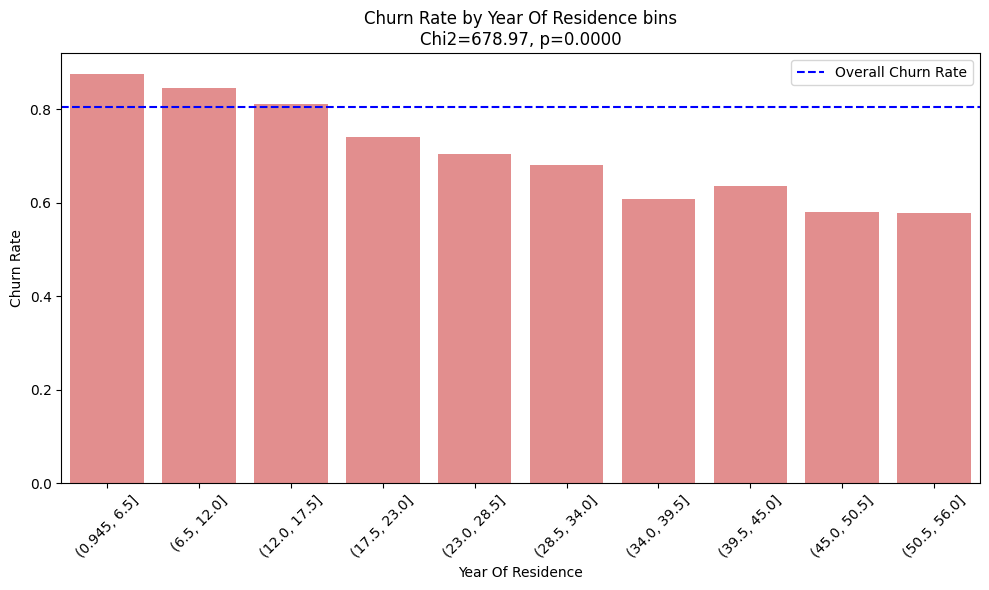

In [296]:
plot_churn_rate_by_numeric_bin(newspaper_df, 'Year Of Residence', bins=10)

Category: reward program
Chi2 statistic: 265.1982
Degrees of freedom: 8
P-value: 1.0287e-52
Cramér's V (effect size): 0.1311
=> 통계적으로 유의미한 관련성이 있습니다.



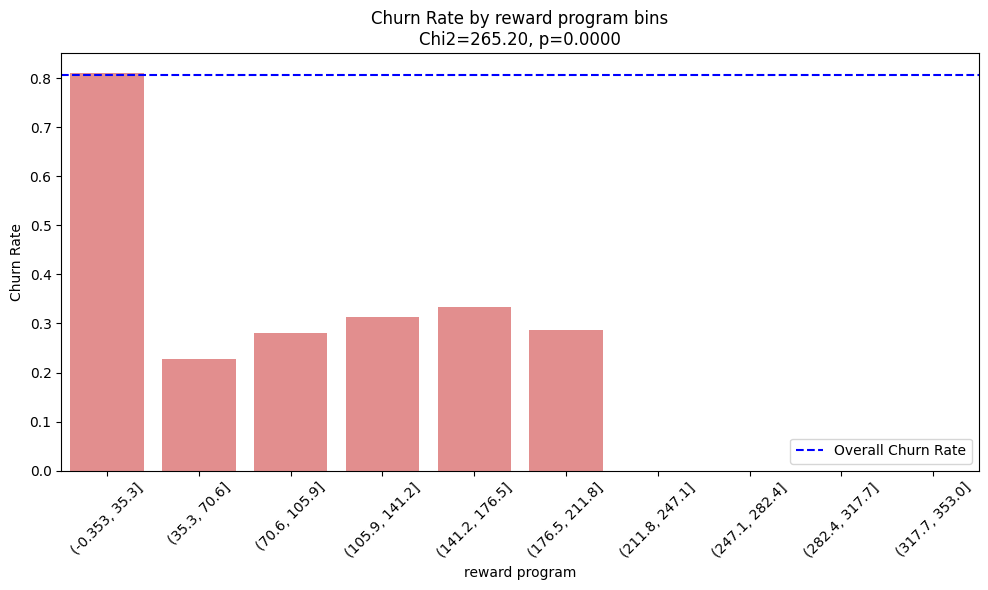

In [297]:
plot_churn_rate_by_numeric_bin(newspaper_df, 'reward program', bins=10)

### 이탈 여부 별 수치형 특성 히트맵
- 결과: 이탈과 잔류에 있어서 변수들 간의 의존 구조는 변하지 않음. 변수들이 서로 어떻게 연관되어 움직이는지는 이탈여부와 무관하게 일정

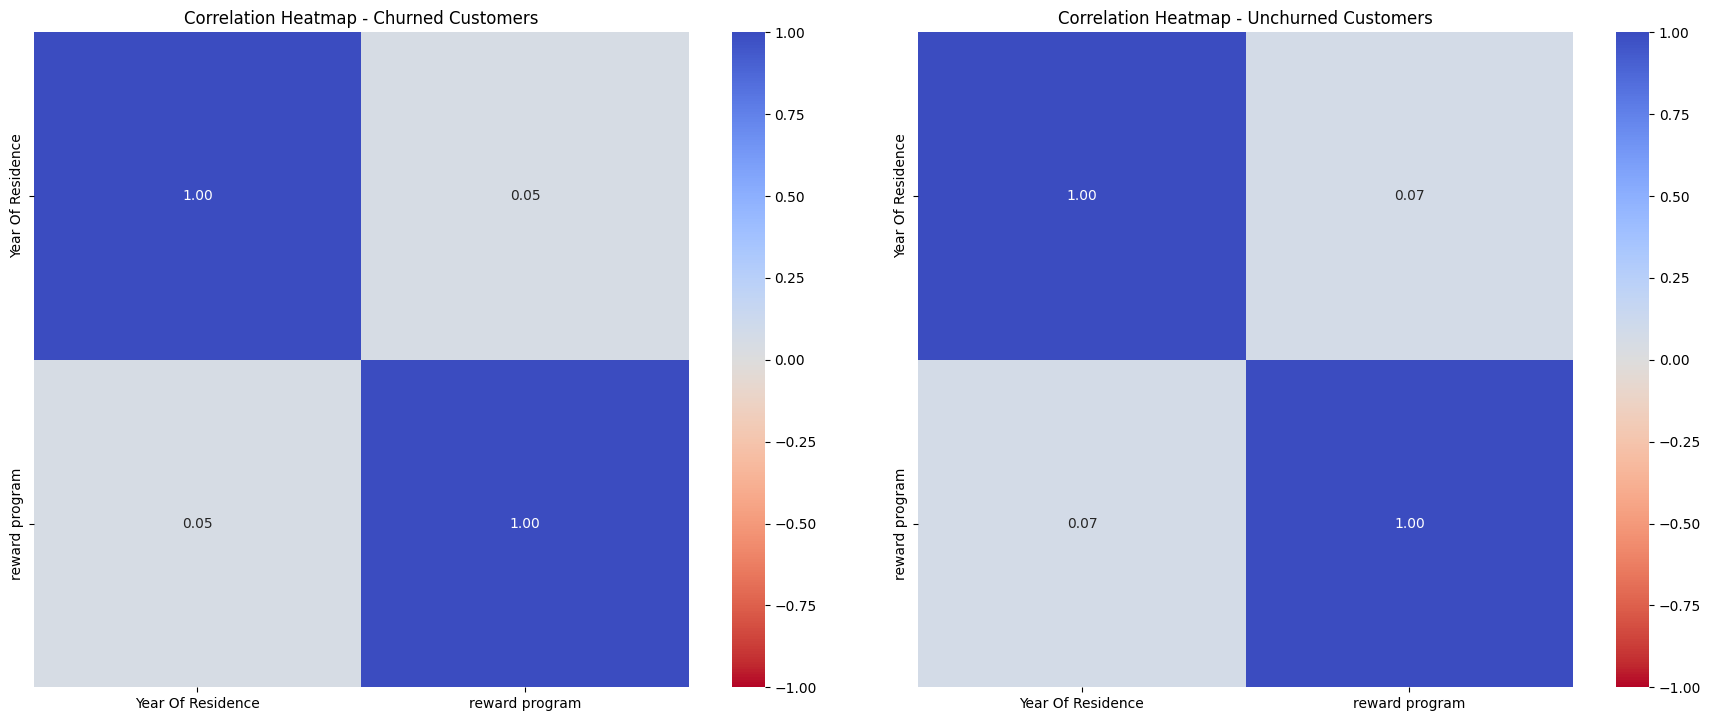

In [298]:
# -----------------------------
# 1. Separate numerical & categorical features
# -----------------------------
numerical = newspaper_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Remove categorical/binary/target variables from the correlation analysis
exclude_cols = ["dummy for Children", "is_churned"]
numerical = [col for col in numerical if col not in exclude_cols]

#print("Numerical Features for correlation:", numerical)

# -----------------------------
# 2. Split data into churned and unchurned
# -----------------------------
df_churned = newspaper_df[newspaper_df['is_churned'] == 1]
df_unchurned = newspaper_df[newspaper_df['is_churned'] == 0]

# -----------------------------
# 3. Compute correlation matrices
# -----------------------------
corr_churned = df_churned[numerical].corr().loc[numerical, numerical]
corr_unchurned = df_unchurned[numerical].corr().loc[numerical, numerical]

# -----------------------------
# 4. Plot side-by-side heatmaps (positive=blue, negative=red)
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(corr_churned, annot=True, fmt=".2f", cmap="coolwarm_r", ax=axes[0],
            vmin=-1, vmax=1, square=True)
axes[0].set_title("Correlation Heatmap - Churned Customers")

sns.heatmap(corr_unchurned, annot=True, fmt=".2f", cmap="coolwarm_r", ax=axes[1],
            vmin=-1, vmax=1, square=True)
axes[1].set_title("Correlation Heatmap - Unchurned Customers")

plt.tight_layout()
plt.show()

#### 1. 범주 별 낮은 빈도수 일반화 문제
- 각 범주형 변수들 중 빈도수가 100 미만인 애들은 일반화의 위험이 있어 others로 묶고 시각화를 시킨 상태
- 다만 머신러닝 단계에서는 빈도수가 100 미만인 범주들도 원핫인코딩에 추가 - 일반화의 위험은 다른 변수들의 유입으로 완화될 것으로 가정
#### 2. 변수들 관의 이탈률 관계 요약
- 'Dummy for children' 변수를 제외한 모든 변수가 '이탈률' 과의 관련성을 보임 (각 변수마다 범주에 따른 이탈률의 차이를 보임, 근거: 카이제곱 검정)
- 각 변수가 이탈률과의 관련성을 보이는 관계로 다양한 변수들 간의 조합으로 뜯어서 분석해볼 필요성이 줄어듦
#### 3. 나이와 소득 연속형 변수 처리에 대한 논의
- 이탈률 간의 관련성을 보기 위해서는 결국 연속형 변수로 바꿨던 나이와 소득 feature를 또 다시 범주형으로 바꿔야 했음
- EDA에서는 소득과 나이를 그대로 범주형으로 두고 분석하되 머신러닝에서 연속형으로 변경해서 전처리하는 안 논의 (연속형으로 바꿔야 하는 당위성) 

## 학습 전처리 - 범주형 데이터 변환

#### 1. 나이 수치형 데이터로 변환
- 성인 기준: **18살 이상**
    - https://www.law.cornell.edu/wex/age_of_majority#:~:text=The%20age%20of%20majority%20refers%20to%20the,or%20the%20right%20to%20sign%20a%20contract.
- 미국 2024년 평균 기대수명: **78.4살**
    - https://www.cdc.gov/nchs/fastats/life-expectancy.htm#:~:text=Both%20sexes:%2078.4%20years.%20Males:%2075.8%20years.%20Females:%2081.1%20years.

**<연령대('Age range'\) 데이터를 정규분포 기반의 수치형 나이로 변환하는 접근의 타당성>**  
- 연령대 범위 내 정규분포 기반의 무작위 나이 생성 방식은 전처리 단계에서 통계적 타당성과 실용성을 모두 갖춘 방법. 각 연령대 범위를 하위 계층으로 간주하고, 해당 범위 내에서 중심값을 기준으로 정규분포를 따라 값을 생성함으로써, 범위 내 연령 분포의 자연스러움을 보존 가능. 
- 이는 층화 샘플링(stratified sampling)과 유사한 원리를 따르며, 층화는 모집단의 하위 그룹 간 분산을 감소시키고 대표성을 보장함으로써 예측 성능 향상에 기여하는 것으로 알려짐 (Lohr, 2021; Cochran, 1977). 
- 또한 머신러닝 모델의 입력값으로 사용되는 순서형 범주형 변수는 단순 레이블 인코딩보다 수치화될 때 모델이 정보의 상대적 크기를 더 잘 이해하게 되며, 특히 로지스틱 회귀나 트리 기반 모델에서 효과적이다 (Zhang et al., 2021). 따라서 해당 방식은 정보 손실 없이 연령대를 정량화하고, 이탈 예측에 중요한 피처로 반영하기 위한 전처리 전략으로서 충분히 정당화될 수 있음.

In [299]:
age_group_bounds = {
    '24 years or less': (18, 24), # 24세 이하 (최소값은 임의로 18로 설정)
    '25-29': (25, 29),
    '30-34': (30, 34),
    '35-39': (35, 39),
    '40-44': (40, 44),
    '45-49': (45, 49),
    '50-54': (50, 54),
    '55-59': (55, 59),
    '60-64': (60, 64),
    '65-69': (65, 69),
    '70-74': (70, 74), 
    '75 years or more': (75, 80) # 나이 최대 값은 80세
}

# 나이 부여 함수
def sample_age(age_range, n_samples):
    low, high = age_group_bounds[age_range]
    mean = (low + high) / 2  # 평균은 범위의 중앙값
    std = (high - low) / 4   # 표준편차는 범위의 1/4 정도로 설정 (약 95%가 범위 안에 들도록)
    sampled = np.random.normal(loc=mean, scale=std, size=n_samples) # 정규분포 샘플링
    return np.clip(np.round(sampled), low, high).astype(int) # 정수로 반올림하고 범위 내로 제한


# Age 컬럼 생성
newspaper_df['Age'] = newspaper_df['Age range'].apply(
    lambda group: sample_age(group, 1)[0] if pd.notnull(group) else np.nan
)

### 2. 소득 구간 정보 범주형 -> 수치형 변환

**<로그 정규분포 기반 소득 샘플링 적용의 타당성>**  
- 미국의 개인 소득 및 가구 소득 분포는 일반적인 정규분포가 아닌, 오른쪽으로 긴 꼬리를 가지는 비대칭 분포, 즉 **로그 정규분포나 파레토 분포(Pareto distribution)**의 형태를 띤다고 널리 알려져 있음. 이러한 특성은 고소득자가 전체 소득에서 차지하는 비중이 높고, 대다수는 중·저소득에 밀집해 있는 현실을 반영. 미국 인구조사국(Census Bureau)의 2023년 자료에 따르면, 가구 중위 소득은 약 $80,610이지만, 상위 10%의 소득 하한은 $234,769에 달하며, 상위 1%의 경우 $631,500 이상을 기록했습니다(DQYDJ, 2024). 이처럼 평균보다 중위값이 훨씬 낮고, 소수의 고소득자가 평균치를 끌어올리는 경향은 정규분포보다는 로그 정규분포가 실제 소득 분포를 더 잘 설명한다는 증거.

- 또한 학술 연구들 역시 이러한 접근을 지지. 많은 통계학 및 경제학 연구에서 소득이나 자산의 분포를 모델링할 때 로그 정규분포를 사용하는 것이 일반적, 이는 모델이 현실을 보다 정확히 반영할 수 있도록 도움 (Clauset et al., 2009; Reed & Jorgensen, 2004). 특히 머신러닝 프로젝트의 입력 변수로 사용되는 소득 정보는 정규성 가정(normality assumption)을 만족할 필요는 없지만, 현실적인 값과 분포를 유지해야 과적합이나 왜곡 없이 일반화 가능한 모델을 만드는 데 기여.

- 따라서 'Income range' 범주를 바탕으로 각 구간의 하한과 상한을 정한 후, 로그 정규분포를 기반으로 현실적인 소득 값을 샘플링하는 방법이 가장 적절하며, 통계적으로도, 실용적으로도, 그리고 실제 소득 분포의 특성과도 부합하는 합리적인 선택.

In [300]:
# 1. 소득 구간별 하한/상한 정의
income_bounds = {
    'Under $20,000': (10000, 19999),
    '$  20,000 - $29,999': (20000, 29999),
    '$  30,000 - $39,999': (30000, 39999),
    '$  40,000 - $49,999': (40000, 49999),
    '$  50,000 - $59,999': (50000, 59999),
    '$  60,000 - $69,999': (60000, 69999),
    '$  70,000 - $79,999': (70000, 79999),
    '$  80,000 - $89,999': (80000, 89999),
    '$  90,000 - $99,999': (90000, 99999),
    '$100,000 - $124,999': (100000, 124999),
    '$125,000 - $149,999': (125000, 149999),
    '$150,000 - $174,999': (150000, 174999),
    '$175,000 - $199,999': (175000, 199999),
    '$200,000 - $249,999': (200000, 249999),
    '$250,000 - $299,999': (250000, 299999),
    '$300,000 - $399,999': (300000, 399999),
    '$400,000 - $499,999': (400000, 499999),
    '$500,000 Plus': (500000, 750000),  # 상위 1% 소득 하한($631,500)을 감안해서 유연함 반영 (출처: DQYDJ, 2024)
}

# 2. 로그 정규분포 기반 샘플링 함수 정의
def sample_log_normal_income(income_range, n_samples=1):
    if income_range not in income_bounds or pd.isnull(income_range):
        return np.nan

    low, high = income_bounds[income_range]
    mu = np.log((low + high) / 2)
    sigma = 0.4  # 분포의 퍼짐 정도 (값이 작을수록 중앙에 집중, 클수록 상한/하한 근처까지 다양하게 퍼짐 => 0.4, 0.5가 중간값 중심 분포를 유지하면서도 현실적인 다양성을 부여하는 수준)

    sample = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)
    clipped = np.clip(sample, low, high)
    return int(round(clipped[0]))

# 3. 적용: 새로운 'Income' 컬럼 생성
newspaper_df['Income'] = newspaper_df['HH Income'].apply(sample_log_normal_income)

### 3. 나이, 소득 전처리 결과 타당성 확인
-  두 변수의 통계 및 히스토그램 확인

In [301]:
newspaper_df[['Age', 'Income']].describe()

,Age,Income
count,15438.000000,15438.000000
mean,52.468260,112328.058686
std,15.597856,112450.000028
min,18.000000,10000.000000
25%,42.000000,39999.000000
50%,52.000000,80000.000000
75%,64.000000,146994.250000
max,80.000000,750000.000000


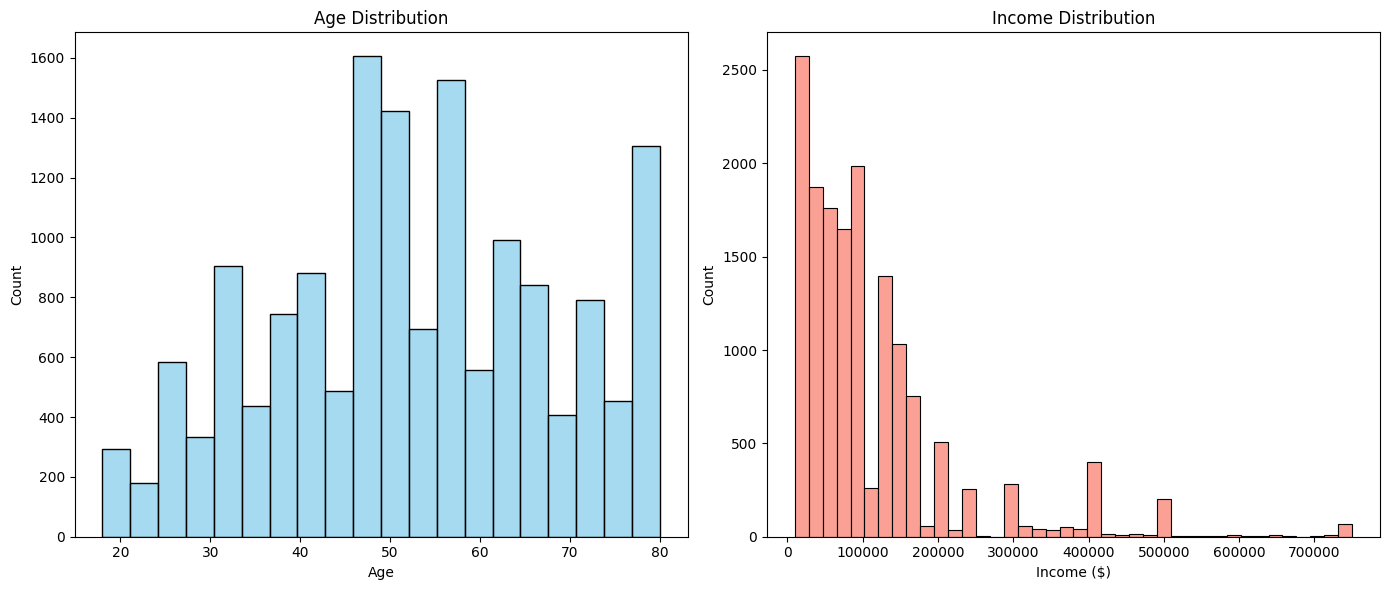

In [302]:
plt.figure(figsize=(14, 6))

#나이 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(newspaper_df['Age'], bins=20, kde=False, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")

# 소득 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(newspaper_df['Income'], bins=40, kde=False, color='salmon')
plt.title("Income Distribution")
plt.xlabel("Income ($)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


- 전처리된 Age 변수는 평균 52.5세, 중간값 52세, 표준편차 15.6의 값을 가지며, 최솟값 18세, 최댓값 80세 범위로 분포하였다. 히스토그램을 통해 살펴보면 30대 후반부터 60대 초반에 이르기까지 높은 밀도를 보이며, 젊은 층과 고령층도 균형 있게 포함되어 있음을 확인할 수 있다. 이는 각 연령대 범위 내에서 정규분포를 기반으로 샘플링한 방식이 실제 성인 구독자층의 인구 구조와 유사하게 반영되었음을 의미함.

- Income 변수는 평균 $112,000, 중간값 $80,000, 표준편차 $111,525의 값을 나타내며, 최대 $750,000까지의 값이 존재한다. 소득 히스토그램은 전형적인 로그 정규분포 형태를 보이며, 대다수의 구독자가 $100,000 이하의 구간에 분포하고, 고소득 구간으로 갈수록 빈도가 급격히 줄어드는 우측 꼬리 구조를 보인다. 이는 실제 미국 소득 분포의 특성과 잘 부합하며, 범주형 소득 데이터를 로그 정규분포 기반으로 수치화한 접근이 현실적인 소득 구조를 왜곡 없이 반영했음을 시각적으로 입증.

### 4 'dummy for Children' binary 변환

- 학습 시 encoding 보다 직관적 이해를 위해 수치형으로 변환

In [303]:
# 'Y' → 1, 'N' → 0
newspaper_df['dummy for Children'] = newspaper_df['dummy for Children'].map({'Y': 1, 'N': 0})

In [304]:
newspaper_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15438 entries, 0 to 15854
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   HH Income           15438 non-null  object
 1   Home Ownership      15438 non-null  object
 2   Ethnicity           15438 non-null  object
 3   dummy for Children  15438 non-null  int64 
 4   Year Of Residence   15438 non-null  int64 
 5   Age range           15438 non-null  object
 6   Language            15438 non-null  object
 7   City                15438 non-null  object
 8   County              15438 non-null  object
 9   weekly fee          15438 non-null  object
 10  Deliveryperiod      15438 non-null  object
 11  Nielsen Prizm       15438 non-null  object
 12  reward program      15438 non-null  int64 
 13  Source Channel      15438 non-null  object
 14  is_churned          15438 non-null  int64 
 15  Age                 15438 non-null  int64 
 16  Income              15438 n

##### 진행 방향
0) 전처리 (범주형: 원핫인코딩 / 수치형: 스탠다드스케일링)
1) 모델 선정 (태연님 지정)
2) 실험 1: 일단 그냥 돌리기 (SMOTE - X, w/stratify)
3) 실험 2: SMOTE 하고 돌리기 (w/stratify)
4) 시험 3: 언더샘플링도 하고 돌려보기
5) 추가 실험: PCA??

- 모델 List (각 모델별 파라미터 Gradient searchCV - chatGPT 활용)
    - Logistic Regression, GradientBoosting - 맹지수
    - XGBoost - 김태연
    - Ensemble - 김태완(월요일에 하세요)
    - RandomForest - 한훈
    - SVM - 최동현
    - (+) Stacking - 추가로 김태연이 해볼게요

##### Encoding

In [305]:
newspaper_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15438 entries, 0 to 15854
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   HH Income           15438 non-null  object
 1   Home Ownership      15438 non-null  object
 2   Ethnicity           15438 non-null  object
 3   dummy for Children  15438 non-null  int64 
 4   Year Of Residence   15438 non-null  int64 
 5   Age range           15438 non-null  object
 6   Language            15438 non-null  object
 7   City                15438 non-null  object
 8   County              15438 non-null  object
 9   weekly fee          15438 non-null  object
 10  Deliveryperiod      15438 non-null  object
 11  Nielsen Prizm       15438 non-null  object
 12  reward program      15438 non-null  int64 
 13  Source Channel      15438 non-null  object
 14  is_churned          15438 non-null  int64 
 15  Age                 15438 non-null  int64 
 16  Income              15438 n

In [310]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTENC

numerical = ['Year Of Residence', 'reward program', 'Age', 'Income']
categorical = ['Home Ownership', 'Ethnicity', 'Language', 'City', 'County', 'weekly fee', 'Deliveryperiod', 'Nielsen Prizm', 'Source Channel']

# 수치형 변수 Standard Scaling 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(newspaper_df[numerical])
scaled_df = pd.DataFrame(scaled_data, columns=numerical, index=newspaper_df.index)

# 범주형 변수 라벨 인코딩 (LabelEncoder 사용)
encoder = LabelEncoder()
encoded_df = pd.DataFrame(index=newspaper_df.index)
for col in categorical:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(newspaper_df[col])

# 범주형 변수 OneHot Encoding
# encoder = OneHotEncoder(sparse_output=False, drop=None) 
# encoded_data = ohe.fit_transform(newspaper_df[categorical])
# encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(categorical), index=newspaper_df.index)

# 인코딩한 데이터프레임 병합
processed_df = pd.concat([scaled_df, encoded_df, newspaper_df[['dummy for Children', 'is_churned']]], axis=1)

# 스케일링 후 데이터 확인
print("Data after scaling:")
print(processed_df.head())

Data after scaling:
   Year Of Residence  reward program       Age    Income  Home Ownership  \
0          -1.067116       -0.115900 -1.568745 -0.685421               1   
1           0.046968       -0.115900  0.034092  3.447617               0   
2          -0.552923       -0.115900 -0.414702  0.036052               0   
3           0.818257       -0.012403  0.162319  0.779678               0   
4           0.818257       -0.115900  0.611113 -0.554291               0   

   Ethnicity  Language  City  County  weekly fee  Deliveryperiod  \
0         23        12    32       0          11               0   
1         72        35    38       1           2              18   
2         33         7    21       1           2              18   
3         17         7    28       1           4              18   
4         33         7    42       1          12              20   

   Nielsen Prizm  Source Channel  dummy for Children  is_churned  
0              1               6               

### 모델 학습 1-1. Logistic Regression

In [317]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score, classification_report
from sklearn.ensemble import GradientBoostingRegressor
from imblearn.over_sampling import SMOTE

X = processed_df.drop('is_churned', axis=1)
y = processed_df['is_churned']

# 학습 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LogisticRegression 모델 생성
lr_reg = LogisticRegression(solver='saga', max_iter=1000)

# 파라미터
params = [
    {'penalty': ['l1'], 'C': [5, 10, 20, 50], 'solver': ['saga'], 'class_weight': ['balanced']}
]

# GridSearchCV 설정 및 학습
grid_search = GridSearchCV(lr_reg, params, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
best_lr = grid_search.best_estimator_
y_proba = best_lr.predict_proba(X_test)[:, 1]

# threshold 탐색
thresholds = np.arange(0.3, 0.71, 0.01)
best_thresh, best_macro_f1 = 0.5, 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_0 = f1_score(y_test, y_pred_t, pos_label=0)
    f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
    macro_f1 = (f1_0 + f1_1) / 2

    if macro_f1 > best_macro_f1:
        best_macro_f1, best_thresh = macro_f1, t

# 최적 threshold 적용
y_pred_best = (y_proba >= best_thresh).astype(int)

print('Logistic Regression')
print('best parameters', grid_search.best_params_)
print(f'Best threshold: {best_thresh:.2f}, Macro F1: {best_macro_f1:.4f}')
print('report', classification_report(y_test, y_pred_best))
print(f'Before SMOTE: {np.bincount(y_train)}')

Logistic Regression
best parameters {'C': 5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
Best threshold: 0.39, Macro F1: 0.6175
report               precision    recall  f1-score   support

           0       0.40      0.36      0.38       601
           1       0.85      0.87      0.86      2487

    accuracy                           0.77      3088
   macro avg       0.62      0.61      0.62      3088
weighted avg       0.76      0.77      0.76      3088

Before SMOTE: [2403 9947]


### 모델 학습 1-2. Logistic Regression (Smotenc 적용)

In [ ]:
from imblearn.over_sampling import SMOTENC

# X_train 컬럼 순서에 맞춰 범주형 변수 인덱스 확인
features = [X_train.columns.get_loc(col) for col in categorical]

# Smotenc 적용
smotenc = SMOTENC(categorical_features=features, random_state=42)
X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train, y_train)

# 파라미터
params = [
    {'penalty': ['l1'], 'C': [30, 40, 50, 60, 70], 'solver': ['saga'], 'class_weight': ['balanced']}
]

# GridSearchCV 설정 및 학습
grid_search = GridSearchCV(lr_reg, params, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
best_lr = grid_search.best_estimator_
y_proba = best_lr.predict_proba(X_test)[:, 1]

# threshold 탐색
thresholds = np.arange(0.3, 0.71, 0.01)
best_thresh, best_macro_f1 = 0.5, 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_0 = f1_score(y_test, y_pred_t, pos_label=0)
    f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
    macro_f1 = (f1_0 + f1_1) / 2

    if macro_f1 > best_macro_f1:
        best_macro_f1, best_thresh = macro_f1, t

# 최적 threshold 적용
y_pred_best = (y_proba >= best_thresh).astype(int)

print('Logistic Regression (Smotenc 적용)')
print('best parameters', grid_search.best_params_)
print(f'Best threshold: {best_thresh:.2f}, Macro F1: {best_macro_f1:.4f}')
print('report', classification_report(y_test, y_pred_best))
print(f'After SMOTE: {np.bincount(y_train_resampled)}')

KeyboardInterrupt: 

### 모델 학습 2-1. GradientBoosting

In [314]:
from sklearn.ensemble import GradientBoostingClassifier

# GradientBoosting Classifier 모델 생성
gb_clf = GradientBoostingClassifier(random_state=42)

# 파라미터
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# GridSearchCV 설정 및 학습
grid_search = GridSearchCV(gb_clf, params, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
best_gb = grid_search.best_estimator_
y_proba = best_gb.predict_proba(X_test)[:, 1]

# threshold 탐색
thresholds = np.arange(0.3, 0.71, 0.01)
best_thresh, best_macro_f1 = 0.5, 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_0 = f1_score(y_test, y_pred_t, pos_label=0)
    f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
    macro_f1 = (f1_0 + f1_1) / 2

    if macro_f1 > best_macro_f1:
        best_macro_f1, best_thresh = macro_f1, t

# 최적 threshold 적용
y_pred_best = (y_proba >= best_thresh).astype(int)

print('GradientBoosting Classifier')
print('best parameters', grid_search.best_params_)
print(f'Best threshold: {best_thresh:.2f}, Macro F1: {best_macro_f1:.4f}')
print('report', classification_report(y_test, y_pred_best))
print(f'Before SMOTE: {np.bincount(y_train)}')

GradientBoosting Classifier
best parameters {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best threshold: 0.67, Macro F1: 0.7583
report               precision    recall  f1-score   support

           0       0.62      0.60      0.61       601
           1       0.90      0.91      0.91      2487

    accuracy                           0.85      3088
   macro avg       0.76      0.76      0.76      3088
weighted avg       0.85      0.85      0.85      3088

Before SMOTE: [2403 9947]


### 모델 학습 2-2. GradientBoosting (Smotenc 적용)

In [ ]:
# X_train 컬럼 순서에 맞춰 범주형 변수 인덱스 확인
features = [X_train.columns.get_loc(col) for col in newspaper_df.columns]

# Smotenc 적용
smotenc = SMOTENC(categorical_features=features, random_state=42)
X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train, y_train)

# 파라미터
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# GridSearchCV 설정 및 학습
grid_search = GridSearchCV(gb_clf, params, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
best_gb = grid_search.best_estimator_
y_proba = best_gb.predict_proba(X_test)[:, 1]

# threshold 탐색
thresholds = np.arange(0.3, 0.71, 0.01)
best_thresh, best_macro_f1 = 0.5, 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_0 = f1_score(y_test, y_pred_t, pos_label=0)
    f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
    macro_f1 = (f1_0 + f1_1) / 2

    if macro_f1 > best_macro_f1:
        best_macro_f1, best_thresh = macro_f1, t

# 최적 threshold 적용
y_pred_best = (y_proba >= best_thresh).astype(int)

print('GradientBoosting Classifier (Smotenc 적용)')
print('best parameters', grid_search.best_params_)
print(f'Best threshold: {best_thresh:.2f}, Macro F1: {best_macro_f1:.4f}')
print('report', classification_report(y_test, y_pred_best))
print(f'After SMOTE: {np.bincount(y_train_resampled)}')

GradientBoosting Classifier (Smotenc 적용)
best parameters {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best threshold: 0.67, Macro F1: 0.7583
report               precision    recall  f1-score   support

           0       0.62      0.60      0.61       601
           1       0.90      0.91      0.91      2487

    accuracy                           0.85      3088
   macro avg       0.76      0.76      0.76      3088
weighted avg       0.85      0.85      0.85      3088

After SMOTE: [9947 9947]


In [ ]:
smotenc = SMOTENC(categorical_features=features, random_state=42)
X_sampled, y_sampled = smotenc.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, random_state=42, stratify=y)

# 파라미터
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# GridSearchCV 설정 및 학습
grid_search = GridSearchCV(gb_clf, params, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
best_gb = grid_search.best_estimator_
y_proba = best_gb.predict_proba(X_test)[:, 1]

# threshold 탐색
thresholds = np.arange(0.3, 0.71, 0.01)
best_thresh, best_macro_f1 = 0.5, 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_0 = f1_score(y_test, y_pred_t, pos_label=0)
    f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
    macro_f1 = (f1_0 + f1_1) / 2

    if macro_f1 > best_macro_f1:
        best_macro_f1, best_thresh = macro_f1, t

# 최적 threshold 적용
y_pred_best = (y_proba >= best_thresh).astype(int)

print('GradientBoosting Classifier (Smotenc 적용)')
print('best parameters', grid_search.best_params_)
print(f'Best threshold: {best_thresh:.2f}, Macro F1: {best_macro_f1:.4f}')
print('report', classification_report(y_test, y_pred_best))
print(f'After SMOTE: {np.bincount(y_train)}')

GradientBoosting Classifier (Smotenc 적용)
best parameters {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best threshold: 0.46, Macro F1: 0.8969
report               precision    recall  f1-score   support

           0       0.92      0.87      0.90      3143
           1       0.87      0.93      0.90      3074

    accuracy                           0.90      6217
   macro avg       0.90      0.90      0.90      6217
weighted avg       0.90      0.90      0.90      6217

After SMOTE: [9291 9360]
